In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import h5py
import rbmg
import rbmg2
from plyer import notification
from scipy.optimize import linear_sum_assignment

# 23 de Marzo

## 1. Función de punto fijo para encontrar m
- La usamos para comparar con la m que tenemos en la simulación de montecarlo y darla por válida

In [3]:
 def f(m,b,J,h):
    return np.tanh(b*(J*m+h))
def fixedpoint(x0,b,J,h,tol):
    error = 1
    while error>tol:
        x = f(x0,b,J,h)
        error = np.abs(x-x0)
        x0 = x
    return x,error

b = 0.7

J = 1
h = 0
x0 = -1
tol = 1e-5

a,b = fixedpoint(x0,b,J,h,tol)
print('Solución m* =',a, "Error =", b)

Solución m* = -1.749951842907626e-05 Error = 7.4997936150131265e-06


In [255]:
def sigma(x):
    return 1/(1+np.exp(-x))-1/2

In [260]:
def fixedpoint(x0,tol):
    error = 1
    while error>tol:
        x = sigma(x0)
        error = np.abs(x-x0)
        x0 = x
    return x,error

x0 = 1
tol = 1e-5

a,b = fixedpoint(x0,tol)
print('Solución m* =',a, "Error =", b)

Solución m* = 8.772600355033688e-07 Error = 2.6317801063990842e-06


## 2. Sampling curie weiss

In [3]:
def cambio_energia(SM,J,h,N,i):
	#Energía promedio
	E = ((2*J/N)*sum(np.delete(SM,i))+2*h)*SM[i]
	return E

In [4]:
def metro(N,J,h,it,beta):
	m = []
	chi = []
	mat = []
	SM = np.random.choice([-1,1],[N])
	
	for j in range (it):
		for k in range(N):
			i = np.random.randint(N)
			ΔE = cambio_energia(SM,J,h,N,i)
			if ΔE<0:
				SM[i] *= -1
			else:
				if np.random.random()<np.exp(-ΔE*beta):
					SM[i] *= -1

		m.append(np.mean(SM))
		chi.append(beta*(np.mean(SM**2) - np.mean(SM)**2))
		mat.append(SM)
		
	return m,chi,mat

In [5]:
def HB(N,J,h,it,beta):
	m = []
	chi = []
	mat = []
	SM = np.random.choice([-1,1],[N])
	
	for j in range (it):
		for k in range(N):
			i = np.random.randint(N)
			ΔE = cambio_energia(SM,J,h,N,i)
			p = 1/(1+np.exp(beta*ΔE))
			if np.random.random() < p:
					SM[i] *= -1

		m.append(np.mean(SM))
		chi.append(beta*(np.mean(SM**2) - np.mean(SM)**2))
		mat.append(SM)
		
	return m,chi,SM

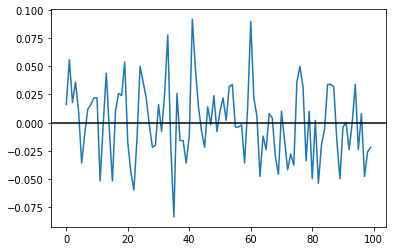

In [6]:
N = 1000
J = 1
h = 0
beta = 0.2
it = 100

a,b,c = metro(N,J,h,it,beta)
fig, ax = plt.subplots()
ax.plot(a)
ax.axhline(y=0, color='black')
plt.show()

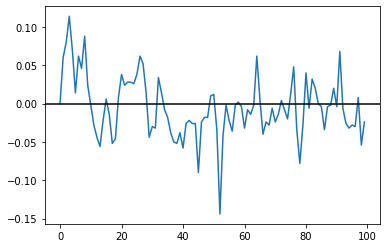

In [7]:
N = 1000
J = 1
h = 0
beta = 0.2
it = 100

a,b,c = HB(N,J,h,it,beta)
fig, ax = plt.subplots()
ax.plot(a)
ax.axhline(y=0, color='black')
plt.show()

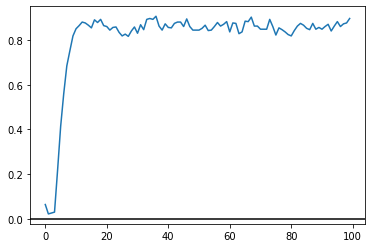

In [8]:
N = 1000
J = 1
h = 0
beta = 1.5
it = 100

a,b,c = metro(N,J,h,it,beta)
fig, ax = plt.subplots()
ax.plot(a)
ax.axhline(y=0, color='black')
plt.show()

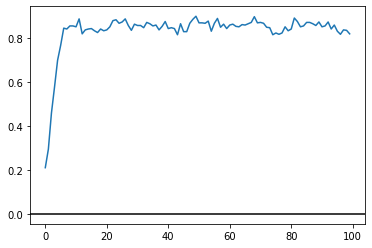

In [9]:
N = 1000
J = 1
h = 0
beta = 1.5
it = 100

a,b,c = HB(N,J,h,it,beta)
fig, ax = plt.subplots()
ax.plot(a)
ax.axhline(y=0, color='black')
plt.show()

In [17]:
L = 1000
J = 1
h = 0
beta = 1.5
it = 80

# c - matriz axb
# Data - Tensor (axb,iter)
nro = 10000
Data = np.zeros([L,nro])

for i in range(nro):
    a,b,c = HB(L,J,h,it,beta)
    Data[:,i] = c

# 1 de Abril
## 2.1 Cambio de variable -1 $\to$ 0

In [6]:
import numpy as np

def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor


In [7]:
import h5py
import torch

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())  


## 3. Training Curie-Weiss 

## 3.1. Dataset entero

### 3.1.1. LR pequeña
- Primero con lr pequeña

In [11]:

D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_4046/1304731591.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [11]:
myRBMG.SetVisBias(D)

myRBMG.train(D)

It =  0 loss tensor(50.0206)
It =  1 loss tensor(24.9876)
It =  2 loss tensor(16.6719)
It =  3 loss tensor(12.4926)
It =  4 loss tensor(9.9978)
It =  5 loss tensor(8.3527)
It =  6 loss tensor(7.1654)
It =  7 loss tensor(6.2680)
It =  8 loss tensor(5.5740)
It =  9 loss tensor(5.0171)
It =  10 loss tensor(4.5632)
It =  11 loss tensor(4.1813)
It =  12 loss tensor(3.8615)
It =  13 loss tensor(3.5829)
It =  14 loss tensor(3.3440)
It =  15 loss tensor(3.1352)
It =  16 loss tensor(2.9502)
It =  17 loss tensor(2.7876)
It =  18 loss tensor(2.6406)
It =  19 loss tensor(2.5098)
It =  20 loss tensor(2.3878)
It =  21 loss tensor(2.2803)
It =  22 loss tensor(2.1802)
It =  23 loss tensor(2.0914)
It =  24 loss tensor(2.0058)
It =  25 loss tensor(1.9298)
It =  26 loss tensor(1.8574)
It =  27 loss tensor(1.7916)
It =  28 loss tensor(1.7309)
It =  29 loss tensor(1.6723)
It =  30 loss tensor(1.6189)
It =  31 loss tensor(1.5689)
It =  32 loss tensor(1.5195)
It =  33 loss tensor(1.4755)
It =  34 loss tensor

It =  277 loss tensor(0.1803)
It =  278 loss tensor(0.1796)
It =  279 loss tensor(0.1791)
It =  280 loss tensor(0.1785)
It =  281 loss tensor(0.1783)
It =  282 loss tensor(0.1780)
It =  283 loss tensor(0.1770)
It =  284 loss tensor(0.1759)
It =  285 loss tensor(0.1750)
It =  286 loss tensor(0.1748)
It =  287 loss tensor(0.1738)
It =  288 loss tensor(0.1735)
It =  289 loss tensor(0.1731)
It =  290 loss tensor(0.1717)
It =  291 loss tensor(0.1719)
It =  292 loss tensor(0.1711)
It =  293 loss tensor(0.1709)
It =  294 loss tensor(0.1705)
It =  295 loss tensor(0.1694)
It =  296 loss tensor(0.1684)
It =  297 loss tensor(0.1686)
It =  298 loss tensor(0.1681)
It =  299 loss tensor(0.1664)
It =  300 loss tensor(0.1668)
It =  301 loss tensor(0.1659)
It =  302 loss tensor(0.1659)
It =  303 loss tensor(0.1657)
It =  304 loss tensor(0.1643)
It =  305 loss tensor(0.1640)
It =  306 loss tensor(0.1630)
It =  307 loss tensor(0.1642)
It =  308 loss tensor(0.1612)
It =  309 loss tensor(0.1617)
It =  310 

It =  551 loss tensor(0.0902)
It =  552 loss tensor(0.0910)
It =  553 loss tensor(0.0899)
It =  554 loss tensor(0.0911)
It =  555 loss tensor(0.0901)
It =  556 loss tensor(0.0904)
It =  557 loss tensor(0.0898)
It =  558 loss tensor(0.0894)
It =  559 loss tensor(0.0892)
It =  560 loss tensor(0.0886)
It =  561 loss tensor(0.0883)
It =  562 loss tensor(0.0889)
It =  563 loss tensor(0.0891)
It =  564 loss tensor(0.0881)
It =  565 loss tensor(0.0890)
It =  566 loss tensor(0.0875)
It =  567 loss tensor(0.0876)
It =  568 loss tensor(0.0877)
It =  569 loss tensor(0.0877)
It =  570 loss tensor(0.0881)
It =  571 loss tensor(0.0883)
It =  572 loss tensor(0.0875)
It =  573 loss tensor(0.0873)
It =  574 loss tensor(0.0870)
It =  575 loss tensor(0.0872)
It =  576 loss tensor(0.0865)
It =  577 loss tensor(0.0873)
It =  578 loss tensor(0.0871)
It =  579 loss tensor(0.0859)
It =  580 loss tensor(0.0860)
It =  581 loss tensor(0.0859)
It =  582 loss tensor(0.0861)
It =  583 loss tensor(0.0848)
It =  584 

It =  825 loss tensor(0.0612)
It =  826 loss tensor(0.0602)
It =  827 loss tensor(0.0606)
It =  828 loss tensor(0.0605)
It =  829 loss tensor(0.0602)
It =  830 loss tensor(0.0599)
It =  831 loss tensor(0.0605)
It =  832 loss tensor(0.0601)
It =  833 loss tensor(0.0588)
It =  834 loss tensor(0.0601)
It =  835 loss tensor(0.0602)
It =  836 loss tensor(0.0594)
It =  837 loss tensor(0.0587)
It =  838 loss tensor(0.0600)
It =  839 loss tensor(0.0592)
It =  840 loss tensor(0.0597)
It =  841 loss tensor(0.0589)
It =  842 loss tensor(0.0590)
It =  843 loss tensor(0.0581)
It =  844 loss tensor(0.0590)
It =  845 loss tensor(0.0593)
It =  846 loss tensor(0.0592)
It =  847 loss tensor(0.0589)
It =  848 loss tensor(0.0592)
It =  849 loss tensor(0.0581)
It =  850 loss tensor(0.0590)
It =  851 loss tensor(0.0583)
It =  852 loss tensor(0.0588)
It =  853 loss tensor(0.0581)
It =  854 loss tensor(0.0581)
It =  855 loss tensor(0.0581)
It =  856 loss tensor(0.0576)
It =  857 loss tensor(0.0587)
It =  858 

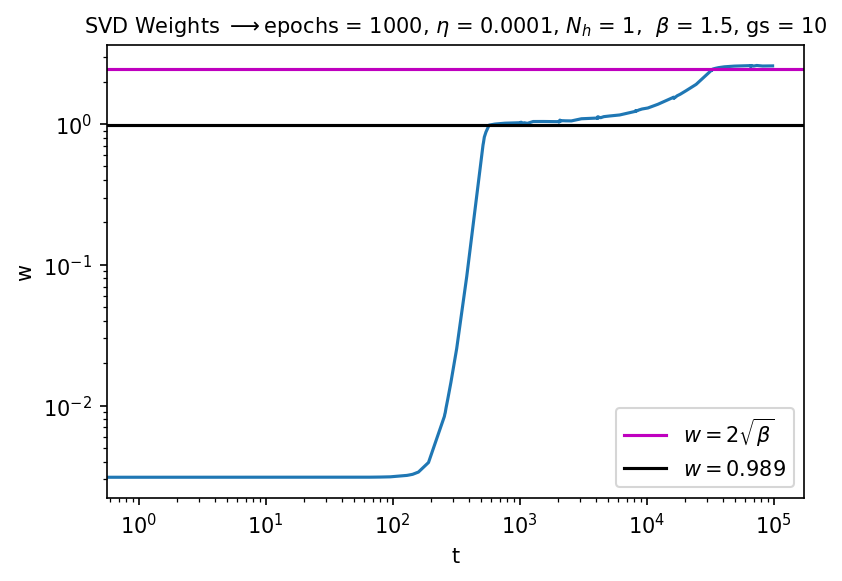

In [10]:
myRBMG.PlotW()
plt.axhline(y=2*np.sqrt(1.5), color='m', linestyle='-', label=r'$w = 2\sqrt{\beta}$')
plt.axhline(y=0.99, color='k', linestyle='-', label='$w = 0.989 $')
plt.title(r'SVD Weights $\longrightarrow$epochs = 1000, $\eta$ = 0.0001, $N_h$ = 1,  $\beta$ = 1.5, gs = 10', fontsize = 10)
plt.xlabel('t')
plt.ylabel('w')
plt.legend()
plt.show()

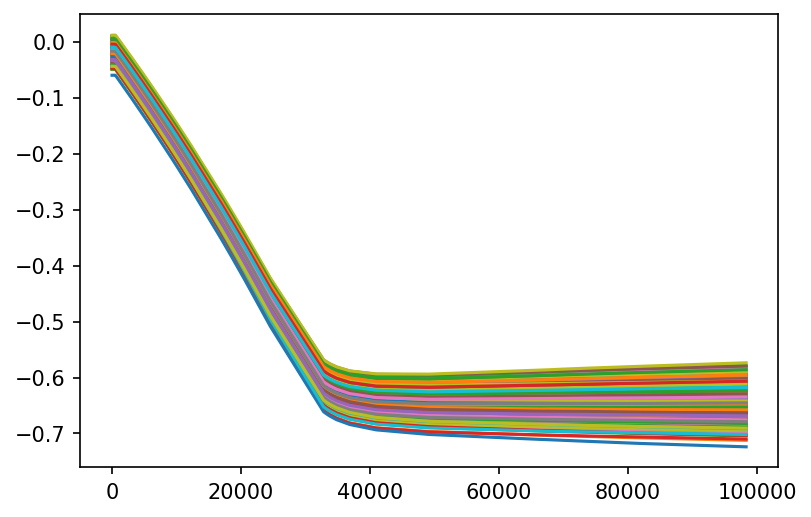

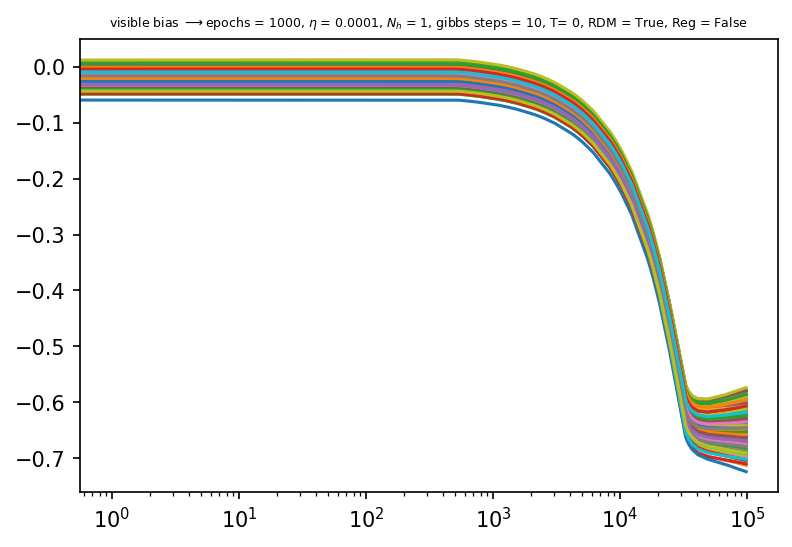

In [12]:
allv = []
allw = []
allh = []
allt = []
alltime = np.sort(f['alltime'])

for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('bias_h'+str(ep)) in f): # check for last time
            break
        
    b_v = torch.tensor(f['bias_v'+str(ep)])
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    W = torch.tensor(f['W'+str(ep)])  
    
    _,s,_ = torch.svd(W)
    allw.append(s.reshape(s.shape[0],1))         
    allv.append(np.array(b_v))
    allh.append(np.array(b_h))
    allt.append(ep)
            
allt = np.array(allt)

plt.figure(dpi=150)

plt.plot(allt,allv)
plt.show()

plt.figure(dpi = 150)
plt.plot(np.array(allt),allv)
plt.xscale('log')
plt.title('visible bias $\longrightarrow$epochs = 1000, $\eta$ = 0.0001, $N_h$ = 1, gibbs steps = 10, T= 0, RDM = True, Reg = False ', fontsize = 6)
plt.show()

Text(0.5, 1.0, 'SVD Weights + visible bias $\to$epochs = 1000, $\\eta$ = 0.0001, $N_h$ = 1, gs = 10')

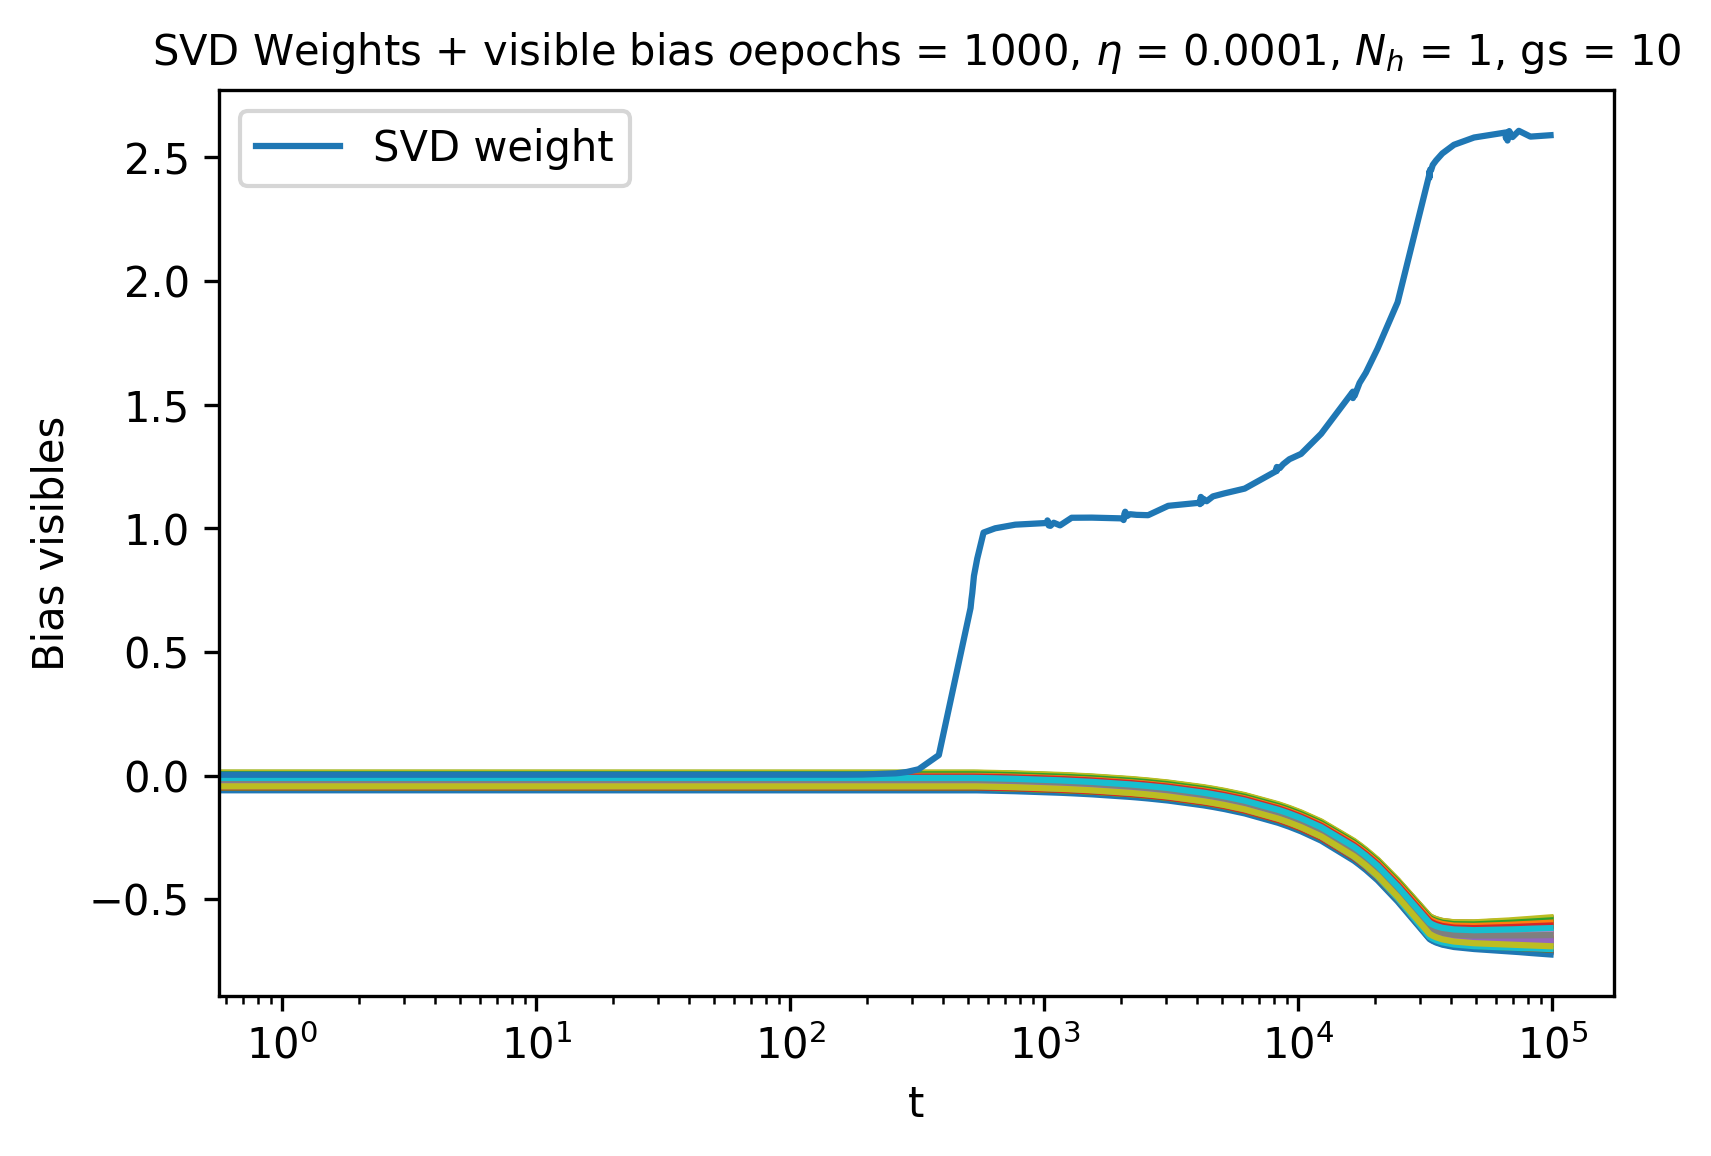

In [14]:
plt.figure(dpi = 300)
plt.plot(np.array(allt),allv)
plt.plot(np.array(allt),allw, label = 'SVD weight')
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('Bias visibles')
plt.legend()
plt.title('SVD Weights + visible bias $\to$epochs = 1000, $\eta$ = 0.0001, $N_h$ = 1, gs = 10', fontsize = 10)

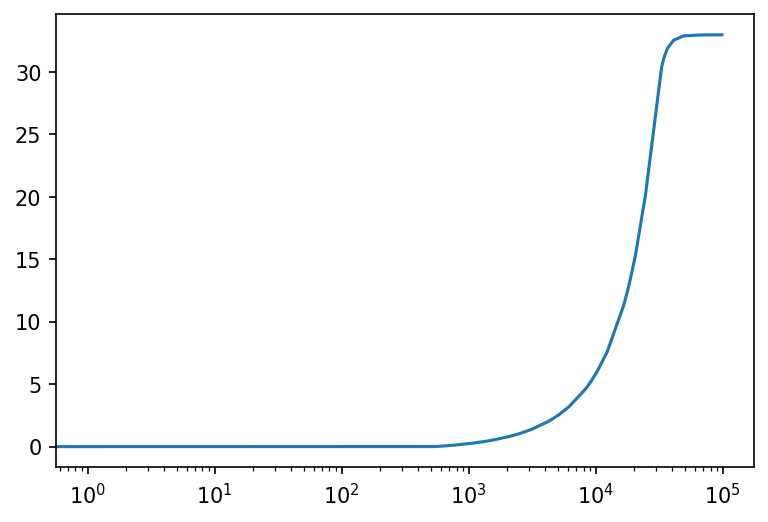

In [12]:
plt.figure(dpi=150)
plt.plot(np.array(allt),allh)
plt.xscale('log')
plt.show()

### proyección u

tensor([1.0115])
tensor([2.5898])


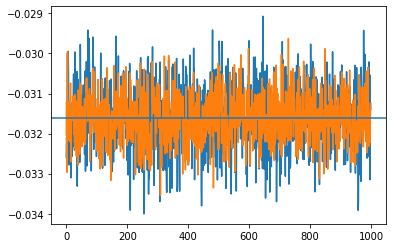

In [33]:
ep=1040
W = torch.tensor(f['W'+str(ep)])   
U,Σ,V=torch.svd(W)
print(Σ)
plt.plot(V[:,0])

ep=98304
W = torch.tensor(f['W'+str(ep)])   
U,Σ,V=torch.svd(W)
plt.plot(V[:,0])
print(Σ)
plt.axhline(y=-1./np.sqrt(1000,))


### 3.1.2 LR grande

In [17]:
u = -torch.ones(1,1000)/np.sqrt(1000)

allw = []
allV = []
allt = []
alltime = np.sort(f['alltime'])

for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('bias_h'+str(ep)) in f): # check for last time
            break 
    W = torch.tensor(f['W'+str(ep)])  
    U,Σ,V=torch.svd(W)

    allw.append(W) 
    allV.append(V[:,0])
    allt.append(ep)
            
allt = np.array(allt)


In [18]:
pr = []
for V in allV:
    pr.append(torch.mm(V.unsqueeze(0),u.t()))

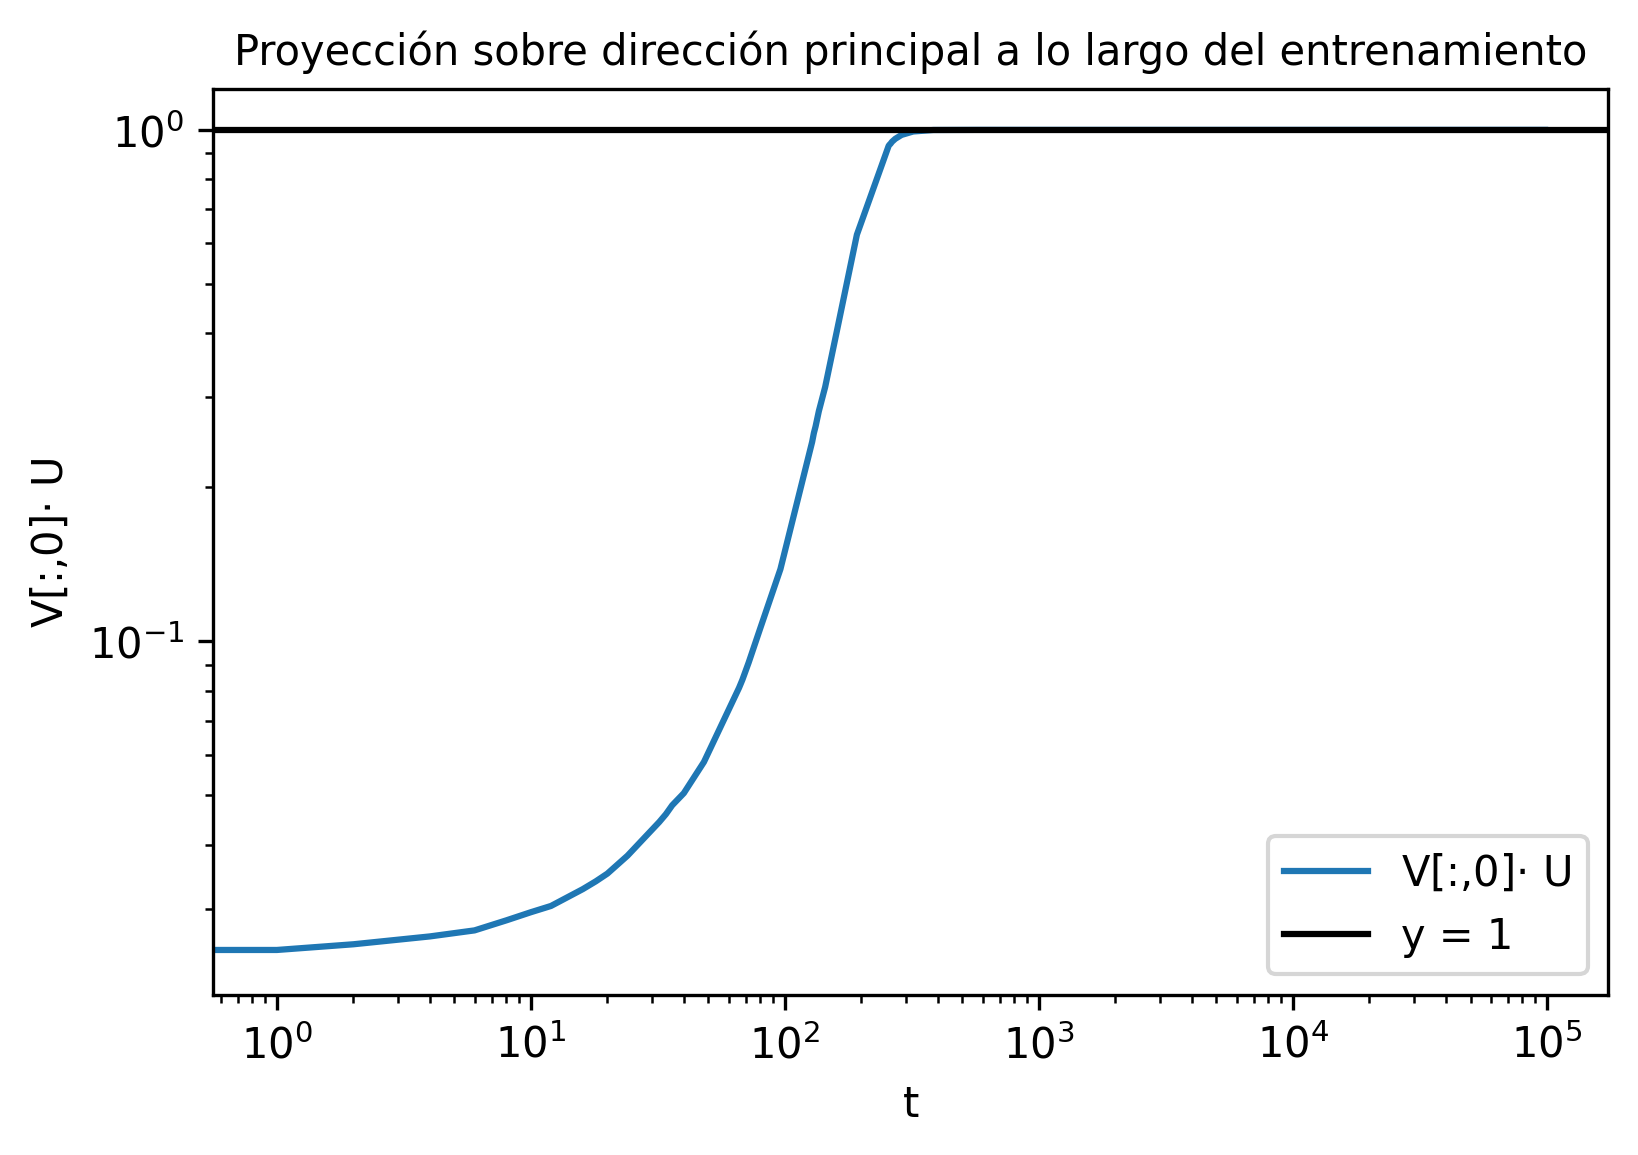

In [20]:
plt.figure(dpi=300)
plt.loglog(allt,pr,label = 'V[:,0]$\cdot$ U')
plt.axhline(y = 1,color = 'k',label = 'y = 1')
plt.xlabel('t')
plt.ylabel('V[:,0]$\cdot$ U')
plt.title('Proyección sobre dirección principal a lo largo del entrenamiento',fontsize = 10)
plt.legend()

- Actua más errático por tener mayor learning rate

In [35]:

D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-3
gibbs_steps = 10
epoch_max = 2000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e2_k10_e2k.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_4880/1409185154.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [36]:
myRBMG.SetVisBias(D)

myRBMG.train(D)

It =  0 loss tensor(50.0870)
It =  1 loss tensor(25.1001)
It =  2 loss tensor(16.7234)
It =  3 loss tensor(12.5438)
It =  4 loss tensor(10.0371)
It =  5 loss tensor(8.3657)
It =  6 loss tensor(7.1677)
It =  7 loss tensor(6.2748)
It =  8 loss tensor(5.5737)
It =  9 loss tensor(5.0144)
It =  10 loss tensor(4.5613)
It =  11 loss tensor(4.1794)
It =  12 loss tensor(3.8605)
It =  13 loss tensor(3.5835)
It =  14 loss tensor(3.3465)
It =  15 loss tensor(3.1347)
It =  16 loss tensor(2.9502)
It =  17 loss tensor(2.7874)
It =  18 loss tensor(2.6407)
It =  19 loss tensor(2.5106)
It =  20 loss tensor(2.3918)
It =  21 loss tensor(2.2808)
It =  22 loss tensor(2.1783)
It =  23 loss tensor(2.0822)
It =  24 loss tensor(2.0053)
It =  25 loss tensor(1.9286)
It =  26 loss tensor(1.8562)
It =  27 loss tensor(1.7844)
It =  28 loss tensor(1.7290)
It =  29 loss tensor(1.6671)
It =  30 loss tensor(1.6195)
It =  31 loss tensor(1.5619)
It =  32 loss tensor(1.5194)
It =  33 loss tensor(1.4835)
It =  34 loss tenso

It =  277 loss tensor(0.1799)
It =  278 loss tensor(0.1796)
It =  279 loss tensor(0.1791)
It =  280 loss tensor(0.1782)
It =  281 loss tensor(0.1781)
It =  282 loss tensor(0.1773)
It =  283 loss tensor(0.1765)
It =  284 loss tensor(0.1759)
It =  285 loss tensor(0.1765)
It =  286 loss tensor(0.1749)
It =  287 loss tensor(0.1736)
It =  288 loss tensor(0.1708)
It =  289 loss tensor(0.1746)
It =  290 loss tensor(0.1721)
It =  291 loss tensor(0.1707)
It =  292 loss tensor(0.1712)
It =  293 loss tensor(0.1700)
It =  294 loss tensor(0.1702)
It =  295 loss tensor(0.1710)
It =  296 loss tensor(0.1670)
It =  297 loss tensor(0.1677)
It =  298 loss tensor(0.1679)
It =  299 loss tensor(0.1671)
It =  300 loss tensor(0.1662)
It =  301 loss tensor(0.1647)
It =  302 loss tensor(0.1655)
It =  303 loss tensor(0.1642)
It =  304 loss tensor(0.1643)
It =  305 loss tensor(0.1634)
It =  306 loss tensor(0.1628)
It =  307 loss tensor(0.1642)
It =  308 loss tensor(0.1612)
It =  309 loss tensor(0.1617)
It =  310 

It =  551 loss tensor(0.0910)
It =  552 loss tensor(0.0906)
It =  553 loss tensor(0.0901)
It =  554 loss tensor(0.0889)
It =  555 loss tensor(0.0898)
It =  556 loss tensor(0.0902)
It =  557 loss tensor(0.0907)
It =  558 loss tensor(0.0890)
It =  559 loss tensor(0.0891)
It =  560 loss tensor(0.0888)
It =  561 loss tensor(0.0878)
It =  562 loss tensor(0.0883)
It =  563 loss tensor(0.0890)
It =  564 loss tensor(0.0883)
It =  565 loss tensor(0.0878)
It =  566 loss tensor(0.0874)
It =  567 loss tensor(0.0872)
It =  568 loss tensor(0.0875)
It =  569 loss tensor(0.0885)
It =  570 loss tensor(0.0879)
It =  571 loss tensor(0.0879)
It =  572 loss tensor(0.0875)
It =  573 loss tensor(0.0878)
It =  574 loss tensor(0.0876)
It =  575 loss tensor(0.0870)
It =  576 loss tensor(0.0874)
It =  577 loss tensor(0.0860)
It =  578 loss tensor(0.0865)
It =  579 loss tensor(0.0865)
It =  580 loss tensor(0.0860)
It =  581 loss tensor(0.0864)
It =  582 loss tensor(0.0866)
It =  583 loss tensor(0.0864)
It =  584 

It =  825 loss tensor(0.0604)
It =  826 loss tensor(0.0605)
It =  827 loss tensor(0.0605)
It =  828 loss tensor(0.0600)
It =  829 loss tensor(0.0605)
It =  830 loss tensor(0.0602)
It =  831 loss tensor(0.0606)
It =  832 loss tensor(0.0600)
It =  833 loss tensor(0.0597)
It =  834 loss tensor(0.0598)
It =  835 loss tensor(0.0598)
It =  836 loss tensor(0.0601)
It =  837 loss tensor(0.0590)
It =  838 loss tensor(0.0599)
It =  839 loss tensor(0.0600)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0587)
It =  842 loss tensor(0.0587)
It =  843 loss tensor(0.0597)
It =  844 loss tensor(0.0590)
It =  845 loss tensor(0.0593)
It =  846 loss tensor(0.0595)
It =  847 loss tensor(0.0596)
It =  848 loss tensor(0.0585)
It =  849 loss tensor(0.0589)
It =  850 loss tensor(0.0584)
It =  851 loss tensor(0.0587)
It =  852 loss tensor(0.0584)
It =  853 loss tensor(0.0589)
It =  854 loss tensor(0.0580)
It =  855 loss tensor(0.0588)
It =  856 loss tensor(0.0578)
It =  857 loss tensor(0.0588)
It =  858 

It =  1095 loss tensor(0.0451)
It =  1096 loss tensor(0.0456)
It =  1097 loss tensor(0.0456)
It =  1098 loss tensor(0.0457)
It =  1099 loss tensor(0.0448)
It =  1100 loss tensor(0.0453)
It =  1101 loss tensor(0.0453)
It =  1102 loss tensor(0.0450)
It =  1103 loss tensor(0.0454)
It =  1104 loss tensor(0.0452)
It =  1105 loss tensor(0.0453)
It =  1106 loss tensor(0.0454)
It =  1107 loss tensor(0.0450)
It =  1108 loss tensor(0.0448)
It =  1109 loss tensor(0.0450)
It =  1110 loss tensor(0.0450)
It =  1111 loss tensor(0.0448)
It =  1112 loss tensor(0.0448)
It =  1113 loss tensor(0.0441)
It =  1114 loss tensor(0.0449)
It =  1115 loss tensor(0.0449)
It =  1116 loss tensor(0.0446)
It =  1117 loss tensor(0.0447)
It =  1118 loss tensor(0.0446)
It =  1119 loss tensor(0.0450)
It =  1120 loss tensor(0.0447)
It =  1121 loss tensor(0.0447)
It =  1122 loss tensor(0.0444)
It =  1123 loss tensor(0.0451)
It =  1124 loss tensor(0.0441)
It =  1125 loss tensor(0.0443)
It =  1126 loss tensor(0.0442)
It =  11

It =  1360 loss tensor(0.0364)
It =  1361 loss tensor(0.0365)
It =  1362 loss tensor(0.0367)
It =  1363 loss tensor(0.0363)
It =  1364 loss tensor(0.0367)
It =  1365 loss tensor(0.0367)
It =  1366 loss tensor(0.0361)
It =  1367 loss tensor(0.0364)
It =  1368 loss tensor(0.0368)
It =  1369 loss tensor(0.0361)
It =  1370 loss tensor(0.0365)
It =  1371 loss tensor(0.0369)
It =  1372 loss tensor(0.0365)
It =  1373 loss tensor(0.0364)
It =  1374 loss tensor(0.0365)
It =  1375 loss tensor(0.0364)
It =  1376 loss tensor(0.0363)
It =  1377 loss tensor(0.0367)
It =  1378 loss tensor(0.0359)
It =  1379 loss tensor(0.0359)
It =  1380 loss tensor(0.0360)
It =  1381 loss tensor(0.0363)
It =  1382 loss tensor(0.0362)
It =  1383 loss tensor(0.0359)
It =  1384 loss tensor(0.0364)
It =  1385 loss tensor(0.0362)
It =  1386 loss tensor(0.0359)
It =  1387 loss tensor(0.0360)
It =  1388 loss tensor(0.0363)
It =  1389 loss tensor(0.0354)
It =  1390 loss tensor(0.0360)
It =  1391 loss tensor(0.0362)
It =  13

It =  1625 loss tensor(0.0308)
It =  1626 loss tensor(0.0300)
It =  1627 loss tensor(0.0309)
It =  1628 loss tensor(0.0307)
It =  1629 loss tensor(0.0307)
It =  1630 loss tensor(0.0307)
It =  1631 loss tensor(0.0307)
It =  1632 loss tensor(0.0303)
It =  1633 loss tensor(0.0304)
It =  1634 loss tensor(0.0310)
It =  1635 loss tensor(0.0306)
It =  1636 loss tensor(0.0305)
It =  1637 loss tensor(0.0302)
It =  1638 loss tensor(0.0304)
It =  1639 loss tensor(0.0307)
It =  1640 loss tensor(0.0305)
It =  1641 loss tensor(0.0307)
It =  1642 loss tensor(0.0305)
It =  1643 loss tensor(0.0303)
It =  1644 loss tensor(0.0302)
It =  1645 loss tensor(0.0304)
It =  1646 loss tensor(0.0304)
It =  1647 loss tensor(0.0303)
It =  1648 loss tensor(0.0304)
It =  1649 loss tensor(0.0305)
It =  1650 loss tensor(0.0302)
It =  1651 loss tensor(0.0303)
It =  1652 loss tensor(0.0300)
It =  1653 loss tensor(0.0303)
It =  1654 loss tensor(0.0300)
It =  1655 loss tensor(0.0300)
It =  1656 loss tensor(0.0300)
It =  16

It =  1890 loss tensor(0.0263)
It =  1891 loss tensor(0.0263)
It =  1892 loss tensor(0.0264)
It =  1893 loss tensor(0.0266)
It =  1894 loss tensor(0.0264)
It =  1895 loss tensor(0.0262)
It =  1896 loss tensor(0.0262)
It =  1897 loss tensor(0.0263)
It =  1898 loss tensor(0.0265)
It =  1899 loss tensor(0.0264)
It =  1900 loss tensor(0.0264)
It =  1901 loss tensor(0.0264)
It =  1902 loss tensor(0.0263)
It =  1903 loss tensor(0.0261)
It =  1904 loss tensor(0.0259)
It =  1905 loss tensor(0.0260)
It =  1906 loss tensor(0.0261)
It =  1907 loss tensor(0.0264)
It =  1908 loss tensor(0.0260)
It =  1909 loss tensor(0.0263)
It =  1910 loss tensor(0.0262)
It =  1911 loss tensor(0.0263)
It =  1912 loss tensor(0.0258)
It =  1913 loss tensor(0.0261)
It =  1914 loss tensor(0.0262)
It =  1915 loss tensor(0.0262)
It =  1916 loss tensor(0.0261)
It =  1917 loss tensor(0.0260)
It =  1918 loss tensor(0.0261)
It =  1919 loss tensor(0.0261)
It =  1920 loss tensor(0.0261)
It =  1921 loss tensor(0.0262)
It =  19

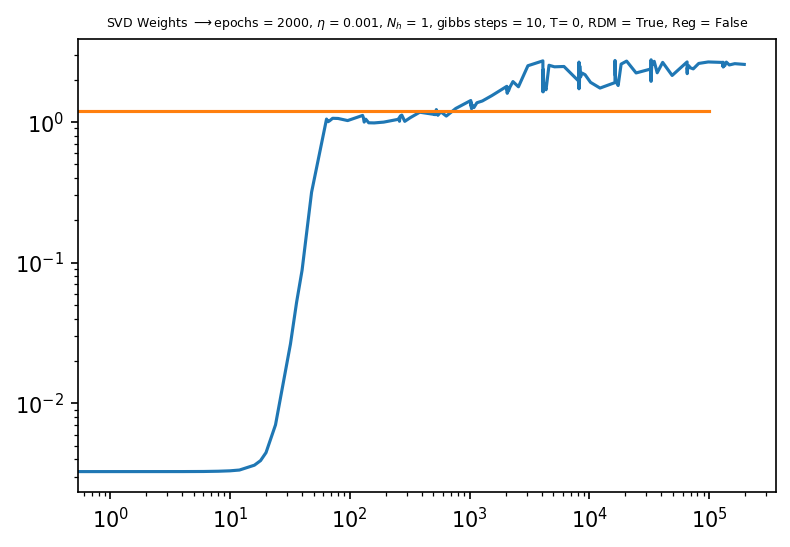

In [37]:
myRBMG.PlotW()
x_inicio = 0
x_fin = 1e5
y = 1.2
plt.plot([x_inicio, x_fin], [y, y])
plt.show()

- Nos quedamos con LR más pequeño. Probamos sólo con 1000 muestras para ver si este escalado es más prominente

## 3.2. Dataset pequeño

### 3.2.1. Menos muestras

In [10]:
d[:,0:1000].shape
D = torch.tensor(d,dtype = torch.float)
D.shape

/tmp/ipykernel_7967/3770614544.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


torch.Size([1000, 10000])

In [11]:

D = torch.tensor(d[:,0:1000],dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWMpeque_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_7967/1981300315.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d[:,0:1000],dtype = torch.float)


In [12]:
myRBMG.SetVisBias(D)

myRBMG.train(D)

It =  0 loss tensor(4.9971)
It =  1 loss tensor(2.5039)
It =  2 loss tensor(1.6664)
It =  3 loss tensor(1.2488)
It =  4 loss tensor(0.9995)
It =  5 loss tensor(0.8338)
It =  6 loss tensor(0.7141)
It =  7 loss tensor(0.6253)
It =  8 loss tensor(0.5548)
It =  9 loss tensor(0.4995)
It =  10 loss tensor(0.4548)
It =  11 loss tensor(0.4164)
It =  12 loss tensor(0.3845)
It =  13 loss tensor(0.3571)
It =  14 loss tensor(0.3335)
It =  15 loss tensor(0.3118)
It =  16 loss tensor(0.2937)
It =  17 loss tensor(0.2775)
It =  18 loss tensor(0.2628)
It =  19 loss tensor(0.2498)
It =  20 loss tensor(0.2384)
It =  21 loss tensor(0.2274)
It =  22 loss tensor(0.2174)
It =  23 loss tensor(0.2084)
It =  24 loss tensor(0.2002)
It =  25 loss tensor(0.1921)
It =  26 loss tensor(0.1848)
It =  27 loss tensor(0.1782)
It =  28 loss tensor(0.1718)
It =  29 loss tensor(0.1663)
It =  30 loss tensor(0.1612)
It =  31 loss tensor(0.1562)
It =  32 loss tensor(0.1515)
It =  33 loss tensor(0.1472)
It =  34 loss tensor(0.1

It =  278 loss tensor(0.0179)
It =  279 loss tensor(0.0178)
It =  280 loss tensor(0.0177)
It =  281 loss tensor(0.0177)
It =  282 loss tensor(0.0176)
It =  283 loss tensor(0.0175)
It =  284 loss tensor(0.0175)
It =  285 loss tensor(0.0175)
It =  286 loss tensor(0.0174)
It =  287 loss tensor(0.0173)
It =  288 loss tensor(0.0173)
It =  289 loss tensor(0.0172)
It =  290 loss tensor(0.0172)
It =  291 loss tensor(0.0171)
It =  292 loss tensor(0.0170)
It =  293 loss tensor(0.0170)
It =  294 loss tensor(0.0169)
It =  295 loss tensor(0.0168)
It =  296 loss tensor(0.0168)
It =  297 loss tensor(0.0167)
It =  298 loss tensor(0.0167)
It =  299 loss tensor(0.0166)
It =  300 loss tensor(0.0166)
It =  301 loss tensor(0.0165)
It =  302 loss tensor(0.0164)
It =  303 loss tensor(0.0164)
It =  304 loss tensor(0.0164)
It =  305 loss tensor(0.0163)
It =  306 loss tensor(0.0162)
It =  307 loss tensor(0.0162)
It =  308 loss tensor(0.0161)
It =  309 loss tensor(0.0161)
It =  310 loss tensor(0.0160)
It =  311 

It =  552 loss tensor(0.0090)
It =  553 loss tensor(0.0090)
It =  554 loss tensor(0.0090)
It =  555 loss tensor(0.0090)
It =  556 loss tensor(0.0089)
It =  557 loss tensor(0.0089)
It =  558 loss tensor(0.0089)
It =  559 loss tensor(0.0089)
It =  560 loss tensor(0.0089)
It =  561 loss tensor(0.0089)
It =  562 loss tensor(0.0089)
It =  563 loss tensor(0.0088)
It =  564 loss tensor(0.0088)
It =  565 loss tensor(0.0088)
It =  566 loss tensor(0.0088)
It =  567 loss tensor(0.0088)
It =  568 loss tensor(0.0088)
It =  569 loss tensor(0.0087)
It =  570 loss tensor(0.0087)
It =  571 loss tensor(0.0087)
It =  572 loss tensor(0.0087)
It =  573 loss tensor(0.0087)
It =  574 loss tensor(0.0087)
It =  575 loss tensor(0.0087)
It =  576 loss tensor(0.0086)
It =  577 loss tensor(0.0086)
It =  578 loss tensor(0.0086)
It =  579 loss tensor(0.0086)
It =  580 loss tensor(0.0086)
It =  581 loss tensor(0.0086)
It =  582 loss tensor(0.0086)
It =  583 loss tensor(0.0085)
It =  584 loss tensor(0.0085)
It =  585 

It =  826 loss tensor(0.0060)
It =  827 loss tensor(0.0060)
It =  828 loss tensor(0.0060)
It =  829 loss tensor(0.0060)
It =  830 loss tensor(0.0060)
It =  831 loss tensor(0.0060)
It =  832 loss tensor(0.0060)
It =  833 loss tensor(0.0060)
It =  834 loss tensor(0.0060)
It =  835 loss tensor(0.0060)
It =  836 loss tensor(0.0059)
It =  837 loss tensor(0.0059)
It =  838 loss tensor(0.0059)
It =  839 loss tensor(0.0059)
It =  840 loss tensor(0.0059)
It =  841 loss tensor(0.0059)
It =  842 loss tensor(0.0059)
It =  843 loss tensor(0.0059)
It =  844 loss tensor(0.0059)
It =  845 loss tensor(0.0059)
It =  846 loss tensor(0.0059)
It =  847 loss tensor(0.0059)
It =  848 loss tensor(0.0059)
It =  849 loss tensor(0.0059)
It =  850 loss tensor(0.0059)
It =  851 loss tensor(0.0058)
It =  852 loss tensor(0.0058)
It =  853 loss tensor(0.0058)
It =  854 loss tensor(0.0058)
It =  855 loss tensor(0.0058)
It =  856 loss tensor(0.0058)
It =  857 loss tensor(0.0058)
It =  858 loss tensor(0.0058)
It =  859 

/home/laura/Fisicas/TFG/Codigo/main/rbmg.py:218: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


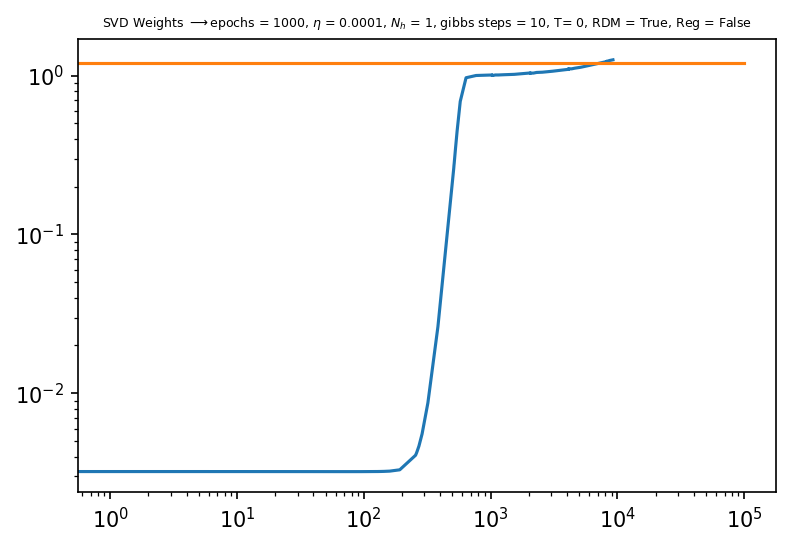

In [13]:
myRBMG.PlotW()
x_inicio = 0
x_fin = 1e5
y = 1.2
plt.plot([x_inicio, x_fin], [y, y])
plt.show()

- parece que hace lo mismo pero nos hemos quedado un poco cortos

In [18]:

D = torch.tensor(d[:,0:1000],dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-3
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWMpeque_1p5_n1_b100_l1e3_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_7967/2100418333.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d[:,0:1000],dtype = torch.float)


In [19]:
myRBMG.SetVisBias(D)

myRBMG.train(D)

It =  0 loss tensor(5.0059)
It =  1 loss tensor(2.4988)
It =  2 loss tensor(1.6651)
It =  3 loss tensor(1.2484)
It =  4 loss tensor(1.0004)
It =  5 loss tensor(0.8328)
It =  6 loss tensor(0.7122)
It =  7 loss tensor(0.6234)
It =  8 loss tensor(0.5550)
It =  9 loss tensor(0.4992)
It =  10 loss tensor(0.4535)
It =  11 loss tensor(0.4157)
It =  12 loss tensor(0.3837)
It =  13 loss tensor(0.3567)
It =  14 loss tensor(0.3325)
It =  15 loss tensor(0.3123)
It =  16 loss tensor(0.2929)
It =  17 loss tensor(0.2769)
It =  18 loss tensor(0.2629)
It =  19 loss tensor(0.2496)
It =  20 loss tensor(0.2373)
It =  21 loss tensor(0.2273)
It =  22 loss tensor(0.2167)
It =  23 loss tensor(0.2077)
It =  24 loss tensor(0.1996)
It =  25 loss tensor(0.1918)
It =  26 loss tensor(0.1848)
It =  27 loss tensor(0.1783)
It =  28 loss tensor(0.1719)
It =  29 loss tensor(0.1661)
It =  30 loss tensor(0.1610)
It =  31 loss tensor(0.1559)
It =  32 loss tensor(0.1513)
It =  33 loss tensor(0.1467)
It =  34 loss tensor(0.1

It =  278 loss tensor(0.0183)
It =  279 loss tensor(0.0176)
It =  280 loss tensor(0.0175)
It =  281 loss tensor(0.0181)
It =  282 loss tensor(0.0174)
It =  283 loss tensor(0.0173)
It =  284 loss tensor(0.0178)
It =  285 loss tensor(0.0174)
It =  286 loss tensor(0.0175)
It =  287 loss tensor(0.0174)
It =  288 loss tensor(0.0172)
It =  289 loss tensor(0.0169)
It =  290 loss tensor(0.0174)
It =  291 loss tensor(0.0171)
It =  292 loss tensor(0.0171)
It =  293 loss tensor(0.0171)
It =  294 loss tensor(0.0170)
It =  295 loss tensor(0.0170)
It =  296 loss tensor(0.0167)
It =  297 loss tensor(0.0163)
It =  298 loss tensor(0.0165)
It =  299 loss tensor(0.0164)
It =  300 loss tensor(0.0162)
It =  301 loss tensor(0.0162)
It =  302 loss tensor(0.0163)
It =  303 loss tensor(0.0162)
It =  304 loss tensor(0.0162)
It =  305 loss tensor(0.0160)
It =  306 loss tensor(0.0161)
It =  307 loss tensor(0.0159)
It =  308 loss tensor(0.0163)
It =  309 loss tensor(0.0158)
It =  310 loss tensor(0.0157)
It =  311 

It =  552 loss tensor(0.0089)
It =  553 loss tensor(0.0091)
It =  554 loss tensor(0.0092)
It =  555 loss tensor(0.0088)
It =  556 loss tensor(0.0090)
It =  557 loss tensor(0.0091)
It =  558 loss tensor(0.0087)
It =  559 loss tensor(0.0090)
It =  560 loss tensor(0.0091)
It =  561 loss tensor(0.0087)
It =  562 loss tensor(0.0089)
It =  563 loss tensor(0.0090)
It =  564 loss tensor(0.0086)
It =  565 loss tensor(0.0089)
It =  566 loss tensor(0.0090)
It =  567 loss tensor(0.0086)
It =  568 loss tensor(0.0088)
It =  569 loss tensor(0.0089)
It =  570 loss tensor(0.0086)
It =  571 loss tensor(0.0088)
It =  572 loss tensor(0.0089)
It =  573 loss tensor(0.0085)
It =  574 loss tensor(0.0088)
It =  575 loss tensor(0.0088)
It =  576 loss tensor(0.0085)
It =  577 loss tensor(0.0087)
It =  578 loss tensor(0.0088)
It =  579 loss tensor(0.0085)
It =  580 loss tensor(0.0087)
It =  581 loss tensor(0.0087)
It =  582 loss tensor(0.0084)
It =  583 loss tensor(0.0086)
It =  584 loss tensor(0.0087)
It =  585 

It =  828 loss tensor(0.0059)
It =  829 loss tensor(0.0061)
It =  830 loss tensor(0.0061)
It =  831 loss tensor(0.0059)
It =  832 loss tensor(0.0060)
It =  833 loss tensor(0.0061)
It =  834 loss tensor(0.0059)
It =  835 loss tensor(0.0060)
It =  836 loss tensor(0.0061)
It =  837 loss tensor(0.0058)
It =  838 loss tensor(0.0060)
It =  839 loss tensor(0.0061)
It =  840 loss tensor(0.0058)
It =  841 loss tensor(0.0060)
It =  842 loss tensor(0.0060)
It =  843 loss tensor(0.0058)
It =  844 loss tensor(0.0060)
It =  845 loss tensor(0.0060)
It =  846 loss tensor(0.0057)
It =  847 loss tensor(0.0059)
It =  848 loss tensor(0.0060)
It =  849 loss tensor(0.0058)
It =  850 loss tensor(0.0059)
It =  851 loss tensor(0.0060)
It =  852 loss tensor(0.0058)
It =  853 loss tensor(0.0059)
It =  854 loss tensor(0.0060)
It =  855 loss tensor(0.0058)
It =  856 loss tensor(0.0059)
It =  857 loss tensor(0.0059)
It =  858 loss tensor(0.0057)
It =  859 loss tensor(0.0059)
It =  860 loss tensor(0.0059)
It =  861 

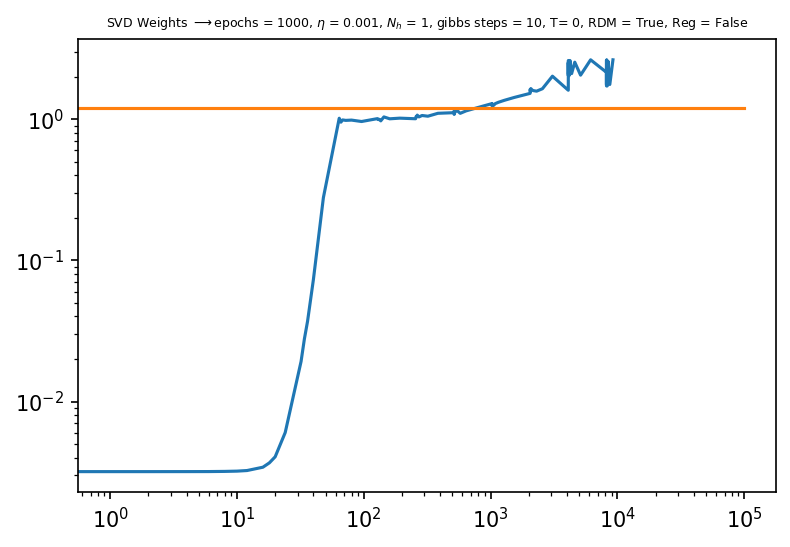

In [20]:
myRBMG.PlotW()
x_inicio = 0
x_fin = 1e5
y = 1.2
plt.plot([x_inicio, x_fin], [y, y])
plt.show()

- Aprende algo por debajo de lo epserado. Creemos que es porque las muesrtras tienen una m un poco menor. Genero muestras con la m deseada para ver si alcanzan justo la beta que deseamos. (sin hacer montecarlo)



## 4 Sampling a diferentes t

- Defino funcion que samplee

In [85]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        mlist = []
        m2list = []
        chilist = []
        
        L = X.shape[0]
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        mlist.append(m.tolist())
        m2list.append(m2.tolist())
        chilist.append((torch.mean(m2)-torch.mean(m)**2).item())
        
        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        mlist.append(m.tolist())
        m2list.append(m2.tolist())
        chilist.append((torch.mean(m2)-torch.mean(m)**2).item())
        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)
        
            mlist.append(m.tolist())
            m2list.append(m2.tolist())
            chilist.append((torch.mean(m2)-torch.mean(m)**2).item())
            
            
        return mlist,chilist,v #estoy guardando todas las m y la última v

- Elijo puntos

/tmp/ipykernel_4573/4196958552.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


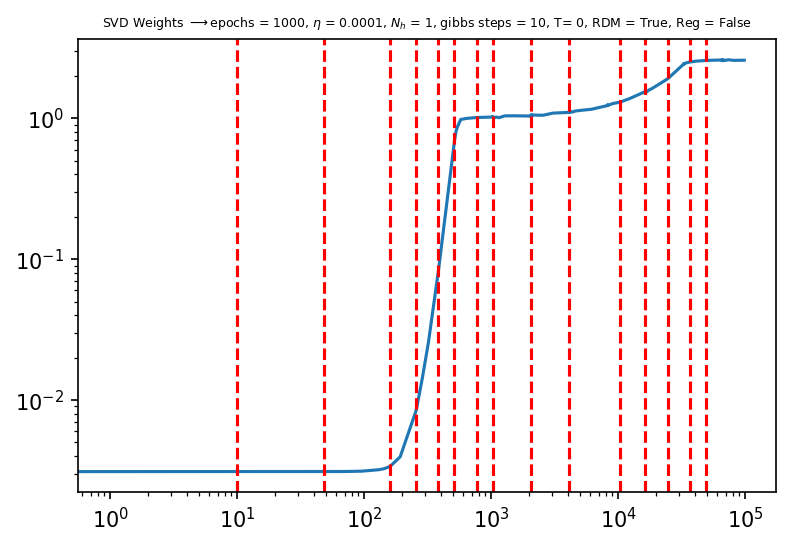

In [41]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())

D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()

xx = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 
for i in xx:
    plt.axvline(x=i, color='r', linestyle='--', label='Línea Vertical')

- Escojo t concreto
- Cargo parámetros de la maquina (W,b_v,b_h)
- Genero X aleatoria
- Ejecuto sampling
- Escojo otro t más alejado
- Cargo parametros
- Inicializo X con la ultima V

### Prueba a un sólo tiempo

In [95]:
tlist = [768]

allt = []
allm = []
allchi  = []
alls = []

filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,5),0.07))

it = 100

for t in tlist:
    ep = int(t)
    print(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    
    

768


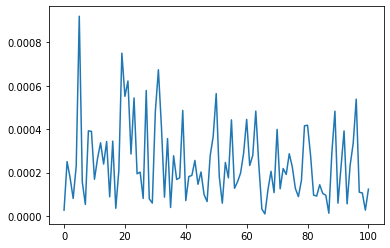

In [109]:
plt.plot((allchi[0]));

In [69]:
m

tensor([0.6790, 0.6620, 0.6650, 0.6670, 0.6400])

### Prueba a 15 tiempos

In [166]:
tlist = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 


allt = []
allm = []
allchi = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)

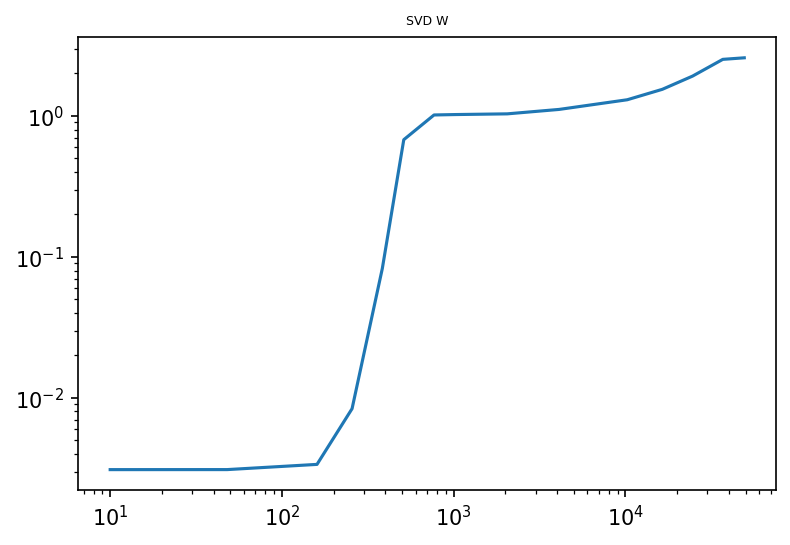

In [167]:
f = h5py.File(filename,'r')
alltime = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 

alls = []
allt = []

for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
    if not(('W'+str(ep)) in f): # check for last time
        break
        
    W = torch.tensor(f['W'+str(ep)])
    _,s,_ = torch.svd(W)
    alls.append(s.reshape(s.shape[0],1))
    allt.append(ep)
    
allt = np.array(allt)
alls = torch.cat(tuple(alls),dim=1)
plt.figure(dpi=150)
plt.title('SVD W', fontsize = 6)
plt.loglog(np.array(allt),alls.t());

In [168]:
alls.shape

torch.Size([1, 15])

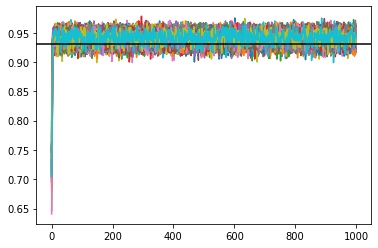

In [169]:
plt.plot(allm[13])
plt.axhline(y=0.93,color = 'k')

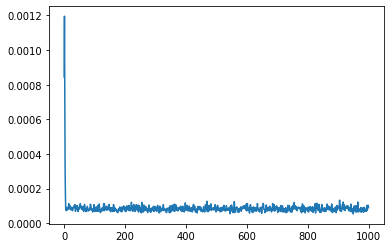

In [170]:
plt.plot(allchi[13])

In [171]:
x = np.transpose(allchi)[998]

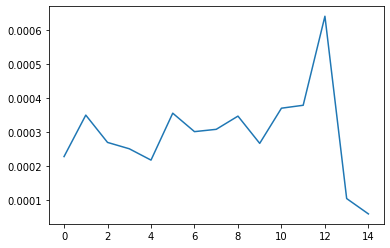

In [172]:
plt.plot(x)

In [173]:
chilast = []
mlast = []
for i in range (0,15):
    chilast.append(allchi[i][998])
    mlast.append(allm[i][998])

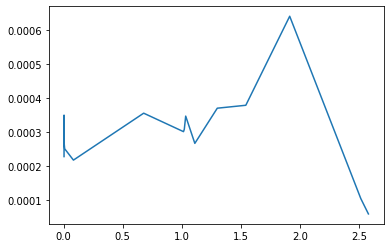

In [174]:
plt.plot(np.array(alls.squeeze(0)),chilast)

### Prueba a 15 tiempos a la reversa

In [179]:
X = torch.ones((1000,10)) #todo unos
X

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [180]:
tlist0 = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 
tlist = sorted(tlist0, reverse=True)

allt = []
allm = []
allchi = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.ones(1000,10) #todo unos

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)

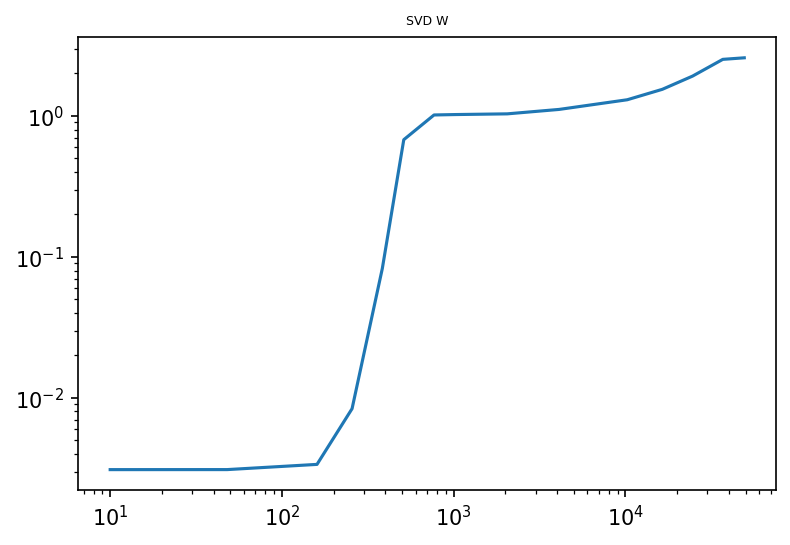

In [181]:
f = h5py.File(filename,'r')
alltime = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 

alls = []
allt = []

for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
    if not(('W'+str(ep)) in f): # check for last time
        break
        
    W = torch.tensor(f['W'+str(ep)])
    _,s,_ = torch.svd(W)
    alls.append(s.reshape(s.shape[0],1))
    allt.append(ep)
    
allt = np.array(allt)
alls = torch.cat(tuple(alls),dim=1)
plt.figure(dpi=150)
plt.title('SVD W', fontsize = 6)
plt.loglog(np.array(allt),alls.t());

In [182]:
alls.shape

torch.Size([1, 15])

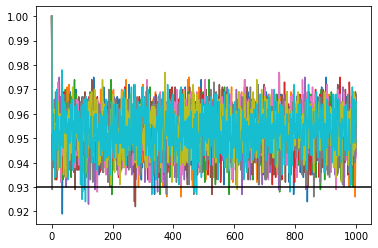

In [188]:
plt.plot(allm[0])
plt.axhline(y=0.93,color = 'k')

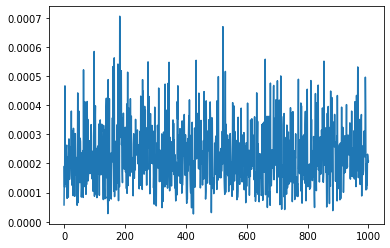

In [189]:
plt.plot(allchi[13])

In [190]:
x = np.transpose(allchi)[998]

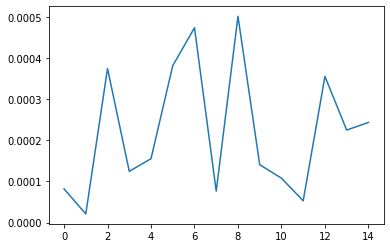

In [191]:
plt.plot(x)

In [192]:
chilast = []
mlast = []
for i in range (0,15):
    chilast.append(allchi[i][998])
    mlast.append(allm[i][998])

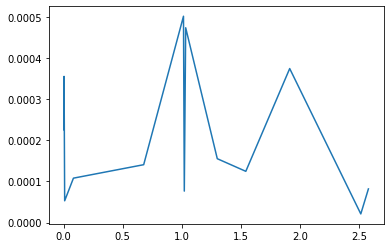

In [196]:
plt.plot(np.array(alls.squeeze(0))[::-1],chilast)

## Comparación con dinámica analitica
- Escala de tiempos dada por lr

/tmp/ipykernel_4573/2274275965.py:38: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,700)
/tmp/ipykernel_4573/2274275965.py:39: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3e-3,1.5)


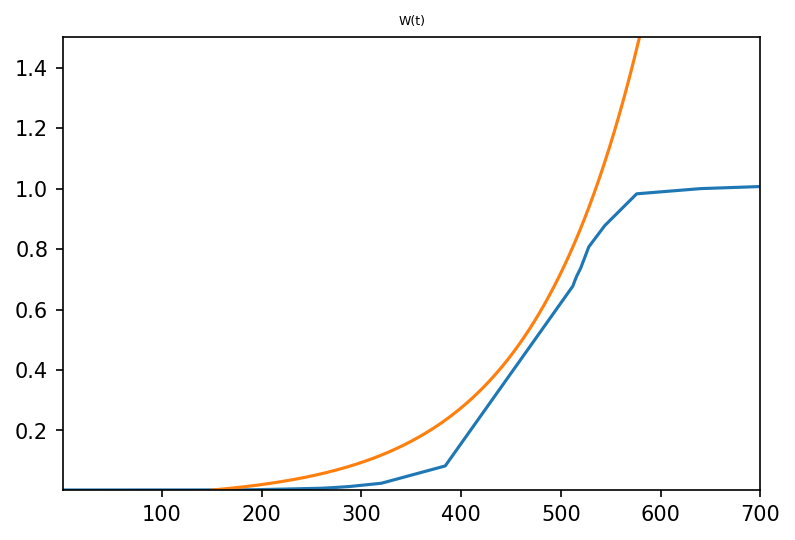

In [321]:
n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()


m0 = 0.885
m = (m0+1)/2

w = []
lr = 1e-4
N = 130

allt = np.linspace(0, 10**3, 1000)
        
for tt in allt:
    
    w.append(3e-3+(1/np.sqrt(1000))*(np.exp((m**2-m+3/4)*tt*lr*N)-1))

plt.title('W(t)', fontsize = 6)
plt.plot(allt+150,w)
plt.xlim(0,700)
plt.ylim(-3e-3,1.5)
plt.gca().set_yscale('linear')
plt.gca().set_xscale('linear')
plt.show()

/tmp/ipykernel_4573/3002588585.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,3)


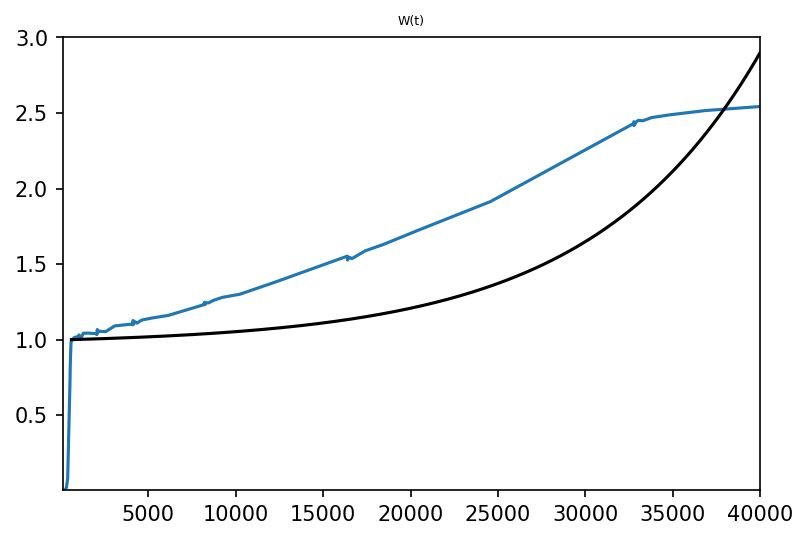

In [329]:
n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()


m0 = 0.885
m = (m0+1)/2

w = []
w1 = []
w2 = []
lr = 1e-4

N = 1.5
#allt = np.linspace(7*10**2, 5*10**4, 1000)

allt = np.linspace(0, 10**5, 1000)
for tt in allt:
    
    w.append(1+(1/np.sqrt(1000))*(np.exp(((m**2)-m+3/4)*tt*lr*N)-1))

plt.title('W(t)', fontsize = 6)
plt.xlim(10**2,4*10**4)
plt.ylim(0,3)
plt.plot(allt+6*10**2,w,'k')
plt.gca().set_yscale('linear')
plt.gca().set_xscale('linear')
plt.show()


## 5. Entrenamiento sin bias oculto
- Creemos que esa es la razon de por qué ese doble crecimiento en los pesos

In [13]:
import h5py
import torch

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())  

D = torch.tensor(d,dtype = torch.float)


/tmp/ipykernel_3851/3397277101.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [14]:

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 2e-4
gibbs_steps = 10
epoch_max = 2000
T = 0



filename = 'files/RDMGnoBH_CWM_1p5_n1_b100_l2e4_k10_e2k.h5'
f = h5py.File(filename,'r') 
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG = rbmg2.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

In [49]:
myRBMG.SetVisBias(D)

myRBMG.train(D)

It =  0 loss tensor(49.9816)
It =  1 loss tensor(24.9986)
It =  2 loss tensor(16.6862)
It =  3 loss tensor(12.5419)
It =  4 loss tensor(10.0315)
It =  5 loss tensor(8.3594)
It =  6 loss tensor(7.1660)
It =  7 loss tensor(6.2696)
It =  8 loss tensor(5.5742)
It =  9 loss tensor(5.0155)
It =  10 loss tensor(4.5616)
It =  11 loss tensor(4.1787)
It =  12 loss tensor(3.8608)
It =  13 loss tensor(3.5841)
It =  14 loss tensor(3.3456)
It =  15 loss tensor(3.1327)
It =  16 loss tensor(2.9516)
It =  17 loss tensor(2.7866)
It =  18 loss tensor(2.6405)
It =  19 loss tensor(2.5074)
It =  20 loss tensor(2.3886)
It =  21 loss tensor(2.2797)
It =  22 loss tensor(2.1801)
It =  23 loss tensor(2.0897)
It =  24 loss tensor(2.0074)
It =  25 loss tensor(1.9290)
It =  26 loss tensor(1.8586)
It =  27 loss tensor(1.7924)
It =  28 loss tensor(1.7300)
It =  29 loss tensor(1.6730)
It =  30 loss tensor(1.6189)
It =  31 loss tensor(1.5678)
It =  32 loss tensor(1.5208)
It =  33 loss tensor(1.4753)
It =  34 loss tenso

It =  277 loss tensor(0.1804)
It =  278 loss tensor(0.1798)
It =  279 loss tensor(0.1791)
It =  280 loss tensor(0.1786)
It =  281 loss tensor(0.1778)
It =  282 loss tensor(0.1773)
It =  283 loss tensor(0.1766)
It =  284 loss tensor(0.1760)
It =  285 loss tensor(0.1754)
It =  286 loss tensor(0.1747)
It =  287 loss tensor(0.1740)
It =  288 loss tensor(0.1737)
It =  289 loss tensor(0.1729)
It =  290 loss tensor(0.1723)
It =  291 loss tensor(0.1718)
It =  292 loss tensor(0.1713)
It =  293 loss tensor(0.1707)
It =  294 loss tensor(0.1701)
It =  295 loss tensor(0.1695)
It =  296 loss tensor(0.1689)
It =  297 loss tensor(0.1682)
It =  298 loss tensor(0.1677)
It =  299 loss tensor(0.1673)
It =  300 loss tensor(0.1666)
It =  301 loss tensor(0.1660)
It =  302 loss tensor(0.1656)
It =  303 loss tensor(0.1651)
It =  304 loss tensor(0.1644)
It =  305 loss tensor(0.1640)
It =  306 loss tensor(0.1635)
It =  307 loss tensor(0.1629)
It =  308 loss tensor(0.1623)
It =  309 loss tensor(0.1618)
It =  310 

It =  551 loss tensor(0.0908)
It =  552 loss tensor(0.0907)
It =  553 loss tensor(0.0906)
It =  554 loss tensor(0.0903)
It =  555 loss tensor(0.0902)
It =  556 loss tensor(0.0902)
It =  557 loss tensor(0.0897)
It =  558 loss tensor(0.0897)
It =  559 loss tensor(0.0895)
It =  560 loss tensor(0.0893)
It =  561 loss tensor(0.0892)
It =  562 loss tensor(0.0890)
It =  563 loss tensor(0.0890)
It =  564 loss tensor(0.0887)
It =  565 loss tensor(0.0885)
It =  566 loss tensor(0.0884)
It =  567 loss tensor(0.0882)
It =  568 loss tensor(0.0882)
It =  569 loss tensor(0.0880)
It =  570 loss tensor(0.0877)
It =  571 loss tensor(0.0877)
It =  572 loss tensor(0.0875)
It =  573 loss tensor(0.0873)
It =  574 loss tensor(0.0870)
It =  575 loss tensor(0.0870)
It =  576 loss tensor(0.0868)
It =  577 loss tensor(0.0867)
It =  578 loss tensor(0.0866)
It =  579 loss tensor(0.0865)
It =  580 loss tensor(0.0862)
It =  581 loss tensor(0.0863)
It =  582 loss tensor(0.0860)
It =  583 loss tensor(0.0858)
It =  584 

It =  825 loss tensor(0.0607)
It =  826 loss tensor(0.0606)
It =  827 loss tensor(0.0605)
It =  828 loss tensor(0.0605)
It =  829 loss tensor(0.0604)
It =  830 loss tensor(0.0603)
It =  831 loss tensor(0.0603)
It =  832 loss tensor(0.0602)
It =  833 loss tensor(0.0602)
It =  834 loss tensor(0.0601)
It =  835 loss tensor(0.0600)
It =  836 loss tensor(0.0599)
It =  837 loss tensor(0.0599)
It =  838 loss tensor(0.0597)
It =  839 loss tensor(0.0597)
It =  840 loss tensor(0.0596)
It =  841 loss tensor(0.0596)
It =  842 loss tensor(0.0595)
It =  843 loss tensor(0.0594)
It =  844 loss tensor(0.0593)
It =  845 loss tensor(0.0593)
It =  846 loss tensor(0.0592)
It =  847 loss tensor(0.0592)
It =  848 loss tensor(0.0591)
It =  849 loss tensor(0.0590)
It =  850 loss tensor(0.0589)
It =  851 loss tensor(0.0589)
It =  852 loss tensor(0.0588)
It =  853 loss tensor(0.0587)
It =  854 loss tensor(0.0587)
It =  855 loss tensor(0.0586)
It =  856 loss tensor(0.0585)
It =  857 loss tensor(0.0584)
It =  858 

It =  1095 loss tensor(0.0457)
It =  1096 loss tensor(0.0457)
It =  1097 loss tensor(0.0456)
It =  1098 loss tensor(0.0456)
It =  1099 loss tensor(0.0456)
It =  1100 loss tensor(0.0456)
It =  1101 loss tensor(0.0455)
It =  1102 loss tensor(0.0454)
It =  1103 loss tensor(0.0454)
It =  1104 loss tensor(0.0454)
It =  1105 loss tensor(0.0453)
It =  1106 loss tensor(0.0453)
It =  1107 loss tensor(0.0450)
It =  1108 loss tensor(0.0450)
It =  1109 loss tensor(0.0450)
It =  1110 loss tensor(0.0452)
It =  1111 loss tensor(0.0451)
It =  1112 loss tensor(0.0450)
It =  1113 loss tensor(0.0450)
It =  1114 loss tensor(0.0450)
It =  1115 loss tensor(0.0449)
It =  1116 loss tensor(0.0449)
It =  1117 loss tensor(0.0448)
It =  1118 loss tensor(0.0448)
It =  1119 loss tensor(0.0448)
It =  1120 loss tensor(0.0447)
It =  1121 loss tensor(0.0447)
It =  1122 loss tensor(0.0446)
It =  1123 loss tensor(0.0446)
It =  1124 loss tensor(0.0445)
It =  1125 loss tensor(0.0444)
It =  1126 loss tensor(0.0445)
It =  11

It =  1360 loss tensor(0.0370)
It =  1361 loss tensor(0.0368)
It =  1362 loss tensor(0.0366)
It =  1363 loss tensor(0.0368)
It =  1364 loss tensor(0.0367)
It =  1365 loss tensor(0.0367)
It =  1366 loss tensor(0.0365)
It =  1367 loss tensor(0.0366)
It =  1368 loss tensor(0.0363)
It =  1369 loss tensor(0.0367)
It =  1370 loss tensor(0.0366)
It =  1371 loss tensor(0.0363)
It =  1372 loss tensor(0.0367)
It =  1373 loss tensor(0.0365)
It =  1374 loss tensor(0.0365)
It =  1375 loss tensor(0.0365)
It =  1376 loss tensor(0.0365)
It =  1377 loss tensor(0.0364)
It =  1378 loss tensor(0.0364)
It =  1379 loss tensor(0.0361)
It =  1380 loss tensor(0.0363)
It =  1381 loss tensor(0.0363)
It =  1382 loss tensor(0.0362)
It =  1383 loss tensor(0.0362)
It =  1384 loss tensor(0.0362)
It =  1385 loss tensor(0.0359)
It =  1386 loss tensor(0.0361)
It =  1387 loss tensor(0.0361)
It =  1388 loss tensor(0.0362)
It =  1389 loss tensor(0.0361)
It =  1390 loss tensor(0.0360)
It =  1391 loss tensor(0.0360)
It =  13

It =  1625 loss tensor(0.0309)
It =  1626 loss tensor(0.0309)
It =  1627 loss tensor(0.0308)
It =  1628 loss tensor(0.0307)
It =  1629 loss tensor(0.0305)
It =  1630 loss tensor(0.0308)
It =  1631 loss tensor(0.0307)
It =  1632 loss tensor(0.0307)
It =  1633 loss tensor(0.0307)
It =  1634 loss tensor(0.0306)
It =  1635 loss tensor(0.0306)
It =  1636 loss tensor(0.0306)
It =  1637 loss tensor(0.0306)
It =  1638 loss tensor(0.0305)
It =  1639 loss tensor(0.0306)
It =  1640 loss tensor(0.0302)
It =  1641 loss tensor(0.0306)
It =  1642 loss tensor(0.0305)
It =  1643 loss tensor(0.0302)
It =  1644 loss tensor(0.0306)
It =  1645 loss tensor(0.0304)
It =  1646 loss tensor(0.0305)
It =  1647 loss tensor(0.0304)
It =  1648 loss tensor(0.0305)
It =  1649 loss tensor(0.0303)
It =  1650 loss tensor(0.0303)
It =  1651 loss tensor(0.0303)
It =  1652 loss tensor(0.0300)
It =  1653 loss tensor(0.0304)
It =  1654 loss tensor(0.0303)
It =  1655 loss tensor(0.0300)
It =  1656 loss tensor(0.0302)
It =  16

It =  1890 loss tensor(0.0265)
It =  1891 loss tensor(0.0262)
It =  1892 loss tensor(0.0264)
It =  1893 loss tensor(0.0263)
It =  1894 loss tensor(0.0262)
It =  1895 loss tensor(0.0265)
It =  1896 loss tensor(0.0265)
It =  1897 loss tensor(0.0264)
It =  1898 loss tensor(0.0263)
It =  1899 loss tensor(0.0264)
It =  1900 loss tensor(0.0263)
It =  1901 loss tensor(0.0264)
It =  1902 loss tensor(0.0261)
It =  1903 loss tensor(0.0261)
It =  1904 loss tensor(0.0263)
It =  1905 loss tensor(0.0263)
It =  1906 loss tensor(0.0263)
It =  1907 loss tensor(0.0262)
It =  1908 loss tensor(0.0262)
It =  1909 loss tensor(0.0261)
It =  1910 loss tensor(0.0263)
It =  1911 loss tensor(0.0262)
It =  1912 loss tensor(0.0262)
It =  1913 loss tensor(0.0262)
It =  1914 loss tensor(0.0260)
It =  1915 loss tensor(0.0262)
It =  1916 loss tensor(0.0260)
It =  1917 loss tensor(0.0261)
It =  1918 loss tensor(0.0258)
It =  1919 loss tensor(0.0261)
It =  1920 loss tensor(0.0258)
It =  1921 loss tensor(0.0261)
It =  19

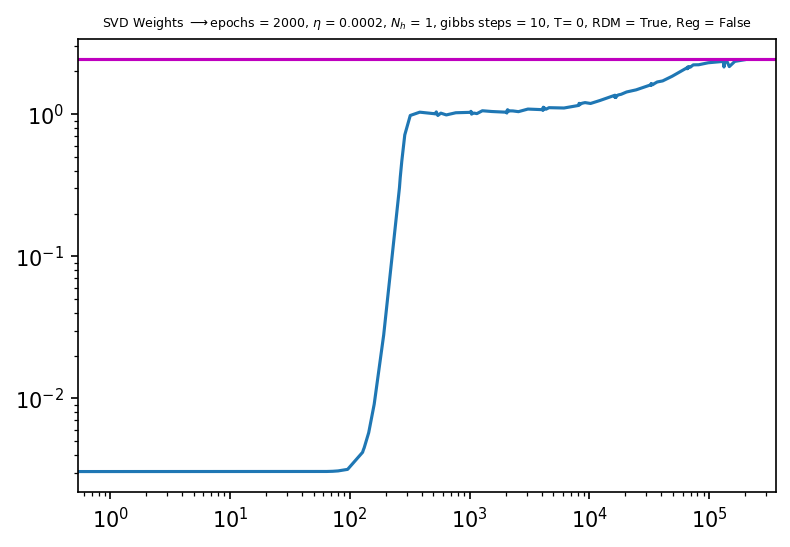

In [18]:
myRBMG.PlotW()

plt.axhline(y=2*np.sqrt(1.5), color='m', linestyle='-', label='Línea Horizontal')


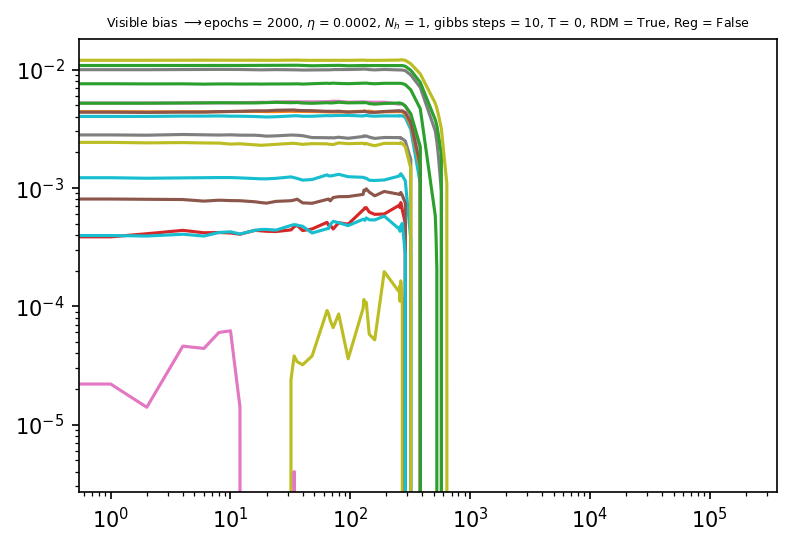

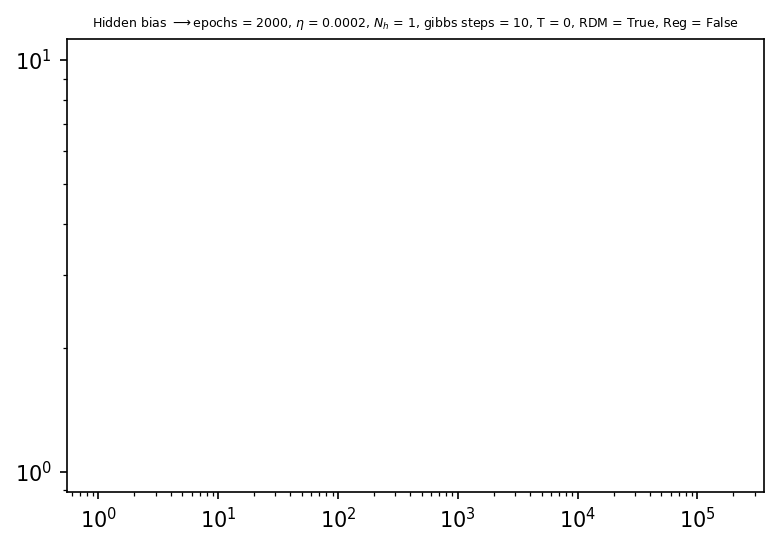

In [51]:
myRBMG.PlotBias()

In [22]:

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-3
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMGnoBH_CWM_1p5_n1_b100_l1e3_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG2 = rbmg2.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

In [53]:
myRBMG2.SetVisBias(D)

myRBMG2.train(D)

It =  0 loss tensor(50.0829)
It =  1 loss tensor(25.0807)
It =  2 loss tensor(16.7198)
It =  3 loss tensor(12.5356)
It =  4 loss tensor(10.0307)
It =  5 loss tensor(8.3596)
It =  6 loss tensor(7.1622)
It =  7 loss tensor(6.2673)
It =  8 loss tensor(5.5730)
It =  9 loss tensor(5.0155)
It =  10 loss tensor(4.5582)
It =  11 loss tensor(4.1761)
It =  12 loss tensor(3.8561)
It =  13 loss tensor(3.5827)
It =  14 loss tensor(3.3448)
It =  15 loss tensor(3.1333)
It =  16 loss tensor(2.9505)
It =  17 loss tensor(2.7867)
It =  18 loss tensor(2.6392)
It =  19 loss tensor(2.5066)
It =  20 loss tensor(2.3869)
It =  21 loss tensor(2.2795)
It =  22 loss tensor(2.1796)
It =  23 loss tensor(2.0887)
It =  24 loss tensor(2.0060)
It =  25 loss tensor(1.9277)
It =  26 loss tensor(1.8565)
It =  27 loss tensor(1.7909)
It =  28 loss tensor(1.7285)
It =  29 loss tensor(1.6719)
It =  30 loss tensor(1.6180)
It =  31 loss tensor(1.5662)
It =  32 loss tensor(1.5188)
It =  33 loss tensor(1.4743)
It =  34 loss tenso

It =  277 loss tensor(0.1798)
It =  278 loss tensor(0.1808)
It =  279 loss tensor(0.1787)
It =  280 loss tensor(0.1780)
It =  281 loss tensor(0.1776)
It =  282 loss tensor(0.1762)
It =  283 loss tensor(0.1760)
It =  284 loss tensor(0.1756)
It =  285 loss tensor(0.1756)
It =  286 loss tensor(0.1754)
It =  287 loss tensor(0.1733)
It =  288 loss tensor(0.1729)
It =  289 loss tensor(0.1714)
It =  290 loss tensor(0.1728)
It =  291 loss tensor(0.1704)
It =  292 loss tensor(0.1701)
It =  293 loss tensor(0.1696)
It =  294 loss tensor(0.1693)
It =  295 loss tensor(0.1682)
It =  296 loss tensor(0.1687)
It =  297 loss tensor(0.1677)
It =  298 loss tensor(0.1677)
It =  299 loss tensor(0.1666)
It =  300 loss tensor(0.1655)
It =  301 loss tensor(0.1654)
It =  302 loss tensor(0.1649)
It =  303 loss tensor(0.1643)
It =  304 loss tensor(0.1636)
It =  305 loss tensor(0.1636)
It =  306 loss tensor(0.1621)
It =  307 loss tensor(0.1624)
It =  308 loss tensor(0.1607)
It =  309 loss tensor(0.1609)
It =  310 

It =  551 loss tensor(0.0906)
It =  552 loss tensor(0.0907)
It =  553 loss tensor(0.0900)
It =  554 loss tensor(0.0904)
It =  555 loss tensor(0.0896)
It =  556 loss tensor(0.0904)
It =  557 loss tensor(0.0894)
It =  558 loss tensor(0.0891)
It =  559 loss tensor(0.0891)
It =  560 loss tensor(0.0886)
It =  561 loss tensor(0.0884)
It =  562 loss tensor(0.0886)
It =  563 loss tensor(0.0887)
It =  564 loss tensor(0.0882)
It =  565 loss tensor(0.0880)
It =  566 loss tensor(0.0883)
It =  567 loss tensor(0.0876)
It =  568 loss tensor(0.0876)
It =  569 loss tensor(0.0870)
It =  570 loss tensor(0.0874)
It =  571 loss tensor(0.0875)
It =  572 loss tensor(0.0871)
It =  573 loss tensor(0.0871)
It =  574 loss tensor(0.0869)
It =  575 loss tensor(0.0867)
It =  576 loss tensor(0.0870)
It =  577 loss tensor(0.0864)
It =  578 loss tensor(0.0861)
It =  579 loss tensor(0.0860)
It =  580 loss tensor(0.0864)
It =  581 loss tensor(0.0857)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0855)
It =  584 

It =  825 loss tensor(0.0606)
It =  826 loss tensor(0.0602)
It =  827 loss tensor(0.0605)
It =  828 loss tensor(0.0604)
It =  829 loss tensor(0.0599)
It =  830 loss tensor(0.0605)
It =  831 loss tensor(0.0599)
It =  832 loss tensor(0.0600)
It =  833 loss tensor(0.0601)
It =  834 loss tensor(0.0601)
It =  835 loss tensor(0.0597)
It =  836 loss tensor(0.0594)
It =  837 loss tensor(0.0596)
It =  838 loss tensor(0.0596)
It =  839 loss tensor(0.0598)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0600)
It =  842 loss tensor(0.0596)
It =  843 loss tensor(0.0595)
It =  844 loss tensor(0.0591)
It =  845 loss tensor(0.0591)
It =  846 loss tensor(0.0589)
It =  847 loss tensor(0.0592)
It =  848 loss tensor(0.0589)
It =  849 loss tensor(0.0585)
It =  850 loss tensor(0.0586)
It =  851 loss tensor(0.0586)
It =  852 loss tensor(0.0583)
It =  853 loss tensor(0.0583)
It =  854 loss tensor(0.0581)
It =  855 loss tensor(0.0581)
It =  856 loss tensor(0.0582)
It =  857 loss tensor(0.0582)
It =  858 

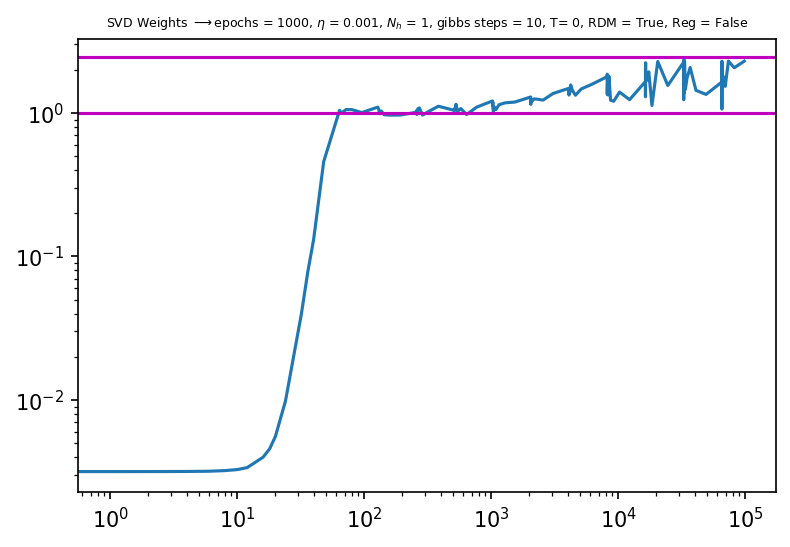

In [25]:
myRBMG2.PlotW()

plt.axhline(y=2*np.sqrt(1.5), color='m', linestyle='-', label='Línea Horizontal')
plt.axhline(y=1, color='m', linestyle='-', label='Línea Horizontal')



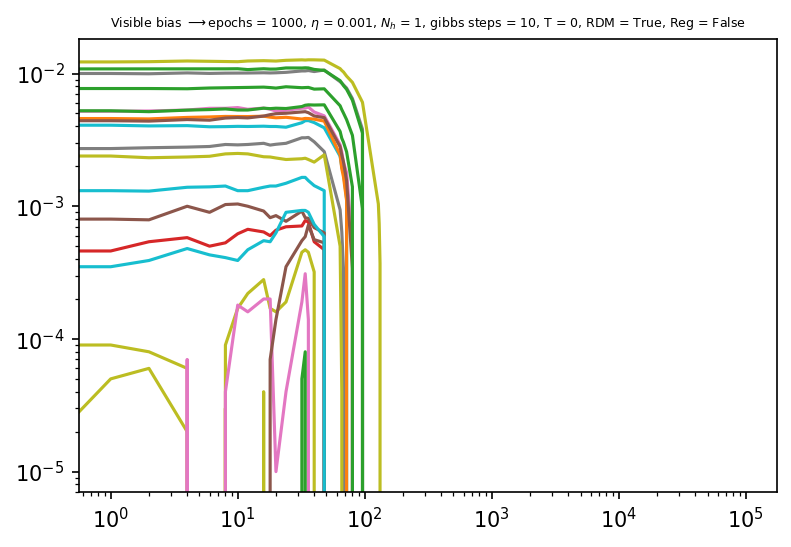

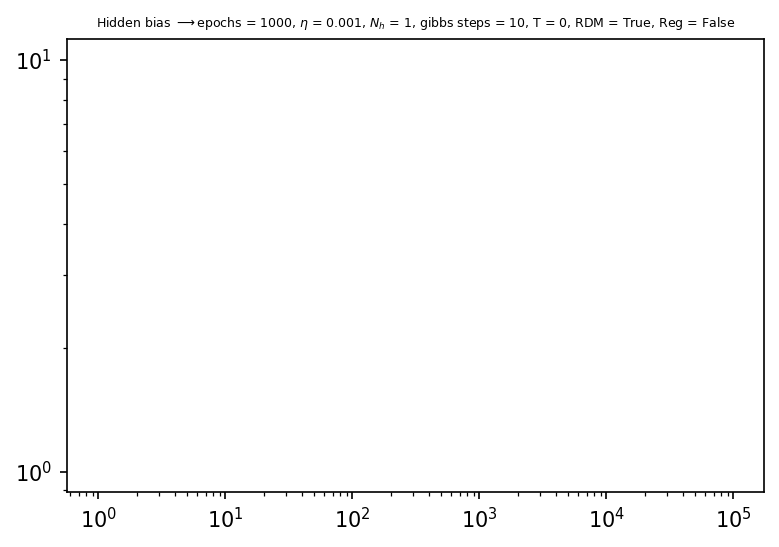

In [55]:
myRBMG2.PlotBias()

## 6. Comparación dinámicas

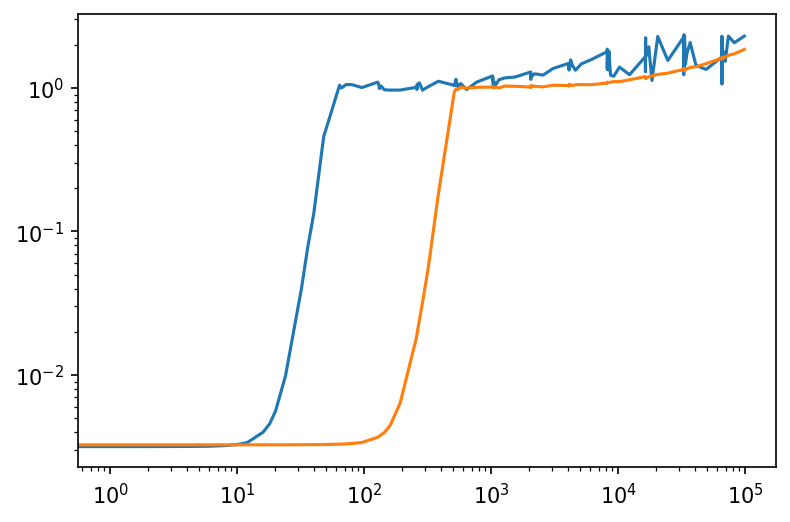

In [15]:
fname1 = 'files/RDMGnoBH_CWM_1p5_n1_b100_l1e3_k10_ek.h5'
fname2 = 'files/RDMGnoBH_CWM_1p5_n1_b100_l1e4_k10_ek.h5'

f1 = h5py.File(fname1,'r')
f2 = h5py.File(fname2,'r')
alltime = np.sort(f1['alltime'])
alls1 = []
allt1 = []
alls2 = []
allt2 = []
        
for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('W'+str(ep)) in f1): # check for last time
        break
        
    W = torch.tensor(f1['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls1.append(s.reshape(s.shape[0],1))
    allt1.append(ep)
    
    W = torch.tensor(f2['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))
    allt2.append(ep)
    
    
allt1 = np.array(allt1)
alls1 = torch.cat(tuple(alls1),dim=1)
allt2 = np.array(allt2)
alls2 = torch.cat(tuple(alls2),dim=1)

plt.figure(dpi=150)
plt.loglog(np.array(allt1),alls1.t())
plt.loglog(np.array(allt2),alls2.t())

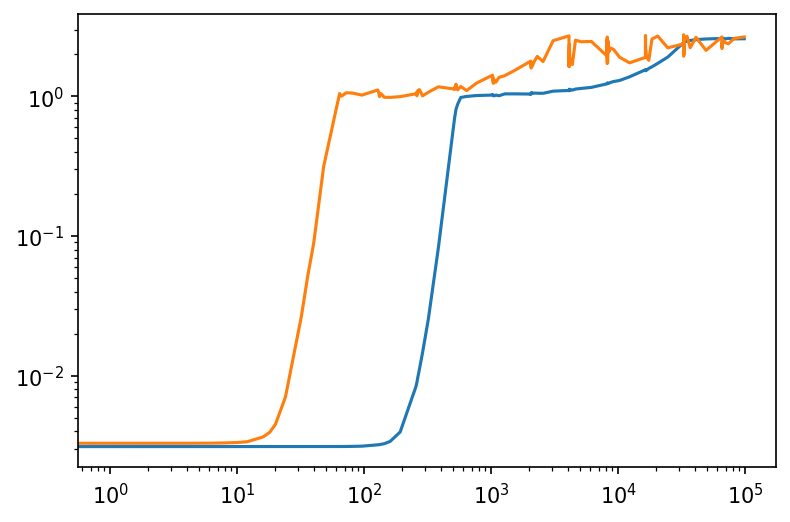

In [16]:
fname1 = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
fname2 = 'files/RDMG_CWM_1p5_n1_b100_l1e2_k10_e2k.h5'
#fname2 = 'files/RDMG_CWMpeque_1p5_n1_b100_l1e4_k10_ek.h5'

f1 = h5py.File(fname1,'r')
f2 = h5py.File(fname2,'r')
alltime = np.sort(f1['alltime'])
alls1 = []
allt1 = []
alls2 = []
allt2 = []
        
for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('W'+str(ep)) in f1): # check for last time
        break
    if not(('W'+str(ep)) in f2): # check for last time
        break
        
    W = torch.tensor(f1['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls1.append(s.reshape(s.shape[0],1))
    allt1.append(ep)
    
    W = torch.tensor(f2['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))
    allt2.append(ep)
    
    
allt1 = np.array(allt1)
alls1 = torch.cat(tuple(alls1),dim=1)
allt2 = np.array(allt2)
alls2 = torch.cat(tuple(alls2),dim=1)

plt.figure(dpi=150)
plt.loglog(np.array(allt1),alls1.t())
plt.loglog(np.array(allt2),alls2.t())

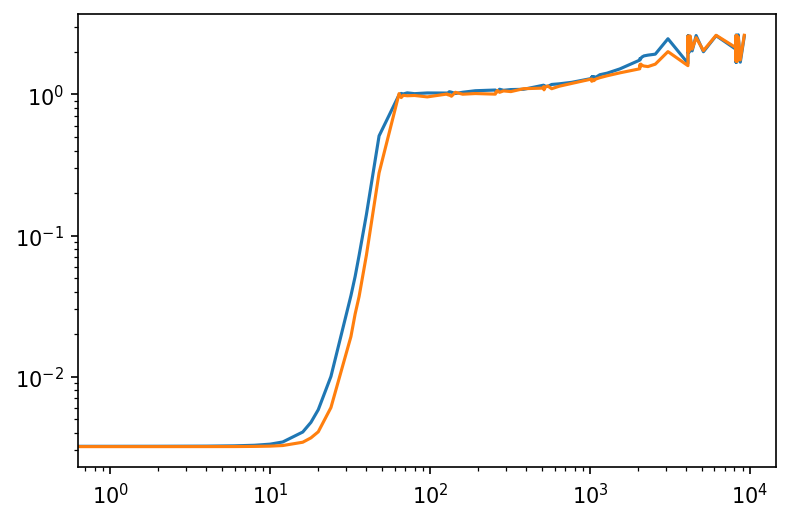

In [17]:
fname1 = 'files/RDMG_CWM_1p5_n1_b1000_l1e3_k10_ek.h5'
fname2 = 'files/RDMG_CWMpeque_1p5_n1_b100_l1e3_k10_ek.h5'

f1 = h5py.File(fname1,'r')
f2 = h5py.File(fname2,'r')
alltime = np.sort(f1['alltime'])
alls1 = []
allt1 = []
alls2 = []
allt2 = []
        
for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('W'+str(ep)) in f1): # check for last time
        break
    if not(('W'+str(ep)) in f2): # check for last time
        break
        
    W = torch.tensor(f1['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls1.append(s.reshape(s.shape[0],1))
    allt1.append(ep)
    
    W = torch.tensor(f2['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))
    allt2.append(ep)
    
    
allt1 = np.array(allt1)
alls1 = torch.cat(tuple(alls1),dim=1)
allt2 = np.array(allt2)
alls2 = torch.cat(tuple(alls2),dim=1)

plt.figure(dpi=150)
plt.loglog(np.array(allt1),alls1.t())
plt.loglog(np.array(allt2),alls2.t())

# 7. PRUEBAS

**Training a temperatura alta**

In [8]:
L = 1000
J = 1
h = 0
beta = 0.2
it = 100

# c - matriz axb
# Data - Tensor (axb,iter)
nro = 5000
Data = np.zeros([L,nro])

for i in range(nro):
    a,b,c = HB(L,J,h,it,beta)
    Data[:,i] = c

In [9]:
filename = "beta0p2.h5py"
import h5py
with h5py.File(filename, "w") as f:
    dset = f.create_dataset("Data", data=Data)

In [2]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

In [3]:
filename = "beta0p2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())


In [4]:
d.shape

torch.Size([1000, 5000])

In [9]:
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-2
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_0p2_n1_b100_l1e2_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_7461/3322134094.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [10]:
myRBMG.SetVisBias(D)
myRBMG.train(D)

It =  0 loss tensor(24.9953)
It =  1 loss tensor(12.4936)
It =  2 loss tensor(8.3256)
It =  3 loss tensor(6.2453)
It =  4 loss tensor(4.9922)
It =  5 loss tensor(4.1651)
It =  6 loss tensor(3.5710)
It =  7 loss tensor(3.1249)
It =  8 loss tensor(2.7768)
It =  9 loss tensor(2.4997)
It =  10 loss tensor(2.2709)
It =  11 loss tensor(2.0843)
It =  12 loss tensor(1.9216)
It =  13 loss tensor(1.7861)
It =  14 loss tensor(1.6667)
It =  15 loss tensor(1.5625)
It =  16 loss tensor(1.4703)
It =  17 loss tensor(1.3887)
It =  18 loss tensor(1.3155)
It =  19 loss tensor(1.2496)
It =  20 loss tensor(1.1895)
It =  21 loss tensor(1.1356)
It =  22 loss tensor(1.0870)
It =  23 loss tensor(1.0412)
It =  24 loss tensor(0.9999)
It =  25 loss tensor(0.9606)
It =  26 loss tensor(0.9250)
It =  27 loss tensor(0.8926)
It =  28 loss tensor(0.8622)
It =  29 loss tensor(0.8333)
It =  30 loss tensor(0.8066)
It =  31 loss tensor(0.7810)
It =  32 loss tensor(0.7571)
It =  33 loss tensor(0.7352)
It =  34 loss tensor(0

It =  277 loss tensor(0.0899)
It =  278 loss tensor(0.0896)
It =  279 loss tensor(0.0892)
It =  280 loss tensor(0.0890)
It =  281 loss tensor(0.0886)
It =  282 loss tensor(0.0883)
It =  283 loss tensor(0.0880)
It =  284 loss tensor(0.0877)
It =  285 loss tensor(0.0874)
It =  286 loss tensor(0.0871)
It =  287 loss tensor(0.0868)
It =  288 loss tensor(0.0865)
It =  289 loss tensor(0.0862)
It =  290 loss tensor(0.0859)
It =  291 loss tensor(0.0856)
It =  292 loss tensor(0.0853)
It =  293 loss tensor(0.0850)
It =  294 loss tensor(0.0847)
It =  295 loss tensor(0.0844)
It =  296 loss tensor(0.0842)
It =  297 loss tensor(0.0839)
It =  298 loss tensor(0.0836)
It =  299 loss tensor(0.0833)
It =  300 loss tensor(0.0830)
It =  301 loss tensor(0.0828)
It =  302 loss tensor(0.0825)
It =  303 loss tensor(0.0822)
It =  304 loss tensor(0.0820)
It =  305 loss tensor(0.0817)
It =  306 loss tensor(0.0814)
It =  307 loss tensor(0.0811)
It =  308 loss tensor(0.0809)
It =  309 loss tensor(0.0807)
It =  310 

It =  551 loss tensor(0.0453)
It =  552 loss tensor(0.0452)
It =  553 loss tensor(0.0451)
It =  554 loss tensor(0.0451)
It =  555 loss tensor(0.0450)
It =  556 loss tensor(0.0449)
It =  557 loss tensor(0.0448)
It =  558 loss tensor(0.0447)
It =  559 loss tensor(0.0446)
It =  560 loss tensor(0.0445)
It =  561 loss tensor(0.0445)
It =  562 loss tensor(0.0444)
It =  563 loss tensor(0.0443)
It =  564 loss tensor(0.0443)
It =  565 loss tensor(0.0442)
It =  566 loss tensor(0.0441)
It =  567 loss tensor(0.0440)
It =  568 loss tensor(0.0439)
It =  569 loss tensor(0.0439)
It =  570 loss tensor(0.0438)
It =  571 loss tensor(0.0437)
It =  572 loss tensor(0.0436)
It =  573 loss tensor(0.0436)
It =  574 loss tensor(0.0435)
It =  575 loss tensor(0.0434)
It =  576 loss tensor(0.0433)
It =  577 loss tensor(0.0432)
It =  578 loss tensor(0.0432)
It =  579 loss tensor(0.0431)
It =  580 loss tensor(0.0431)
It =  581 loss tensor(0.0429)
It =  582 loss tensor(0.0429)
It =  583 loss tensor(0.0428)
It =  584 

It =  825 loss tensor(0.0302)
It =  826 loss tensor(0.0302)
It =  827 loss tensor(0.0302)
It =  828 loss tensor(0.0301)
It =  829 loss tensor(0.0301)
It =  830 loss tensor(0.0301)
It =  831 loss tensor(0.0301)
It =  832 loss tensor(0.0300)
It =  833 loss tensor(0.0300)
It =  834 loss tensor(0.0299)
It =  835 loss tensor(0.0299)
It =  836 loss tensor(0.0299)
It =  837 loss tensor(0.0298)
It =  838 loss tensor(0.0298)
It =  839 loss tensor(0.0298)
It =  840 loss tensor(0.0297)
It =  841 loss tensor(0.0297)
It =  842 loss tensor(0.0296)
It =  843 loss tensor(0.0296)
It =  844 loss tensor(0.0296)
It =  845 loss tensor(0.0295)
It =  846 loss tensor(0.0295)
It =  847 loss tensor(0.0295)
It =  848 loss tensor(0.0294)
It =  849 loss tensor(0.0294)
It =  850 loss tensor(0.0294)
It =  851 loss tensor(0.0293)
It =  852 loss tensor(0.0293)
It =  853 loss tensor(0.0293)
It =  854 loss tensor(0.0292)
It =  855 loss tensor(0.0292)
It =  856 loss tensor(0.0292)
It =  857 loss tensor(0.0291)
It =  858 

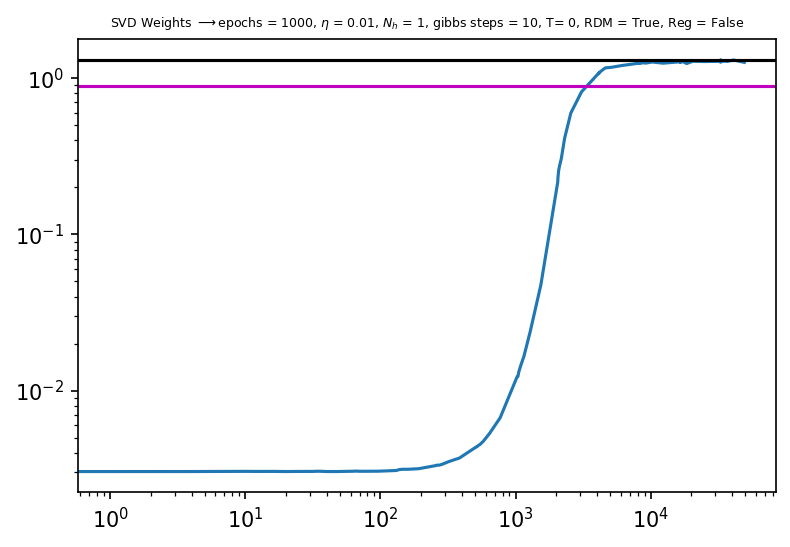

In [18]:
myRBMG.PlotW()
plt.axhline(y=2*np.sqrt(0.2), color='m', linestyle='-', label='Línea Horizontal')
plt.axhline(y=1.3, color='k', linestyle='-', label='Línea Horizontal')

**Training a misma temperatura (baja) pero muestras mas pequeñas (Cadenas de tamaño 100)**

In [24]:
L = 100
J = 1
h = 0
beta = 1.5
it = 80

# c - matriz axb
# Data - Tensor (axb,iter)

nro = 10000
Data = np.zeros([L,nro])

for i in range(nro):
    a,b,c = HB(L,J,h,it,beta)
    Data[:,i] = c
    
filename = "beta1p5L100.h5py"
import h5py
with h5py.File(filename, "w") as f:
    dset = f.create_dataset("Data", data=Data)

In [4]:

filename = "beta1p5L100.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG2 = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_5374/333801749.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [4]:
myRBMG2.SetVisBias(D)
myRBMG2.train(D)

It =  0 loss tensor(50.0302)
It =  1 loss tensor(24.9937)
It =  2 loss tensor(16.6499)
It =  3 loss tensor(12.4772)
It =  4 loss tensor(10.0155)
It =  5 loss tensor(8.3459)
It =  6 loss tensor(7.1321)
It =  7 loss tensor(6.2502)
It =  8 loss tensor(5.5519)
It =  9 loss tensor(5.0036)
It =  10 loss tensor(4.5407)
It =  11 loss tensor(4.1658)
It =  12 loss tensor(3.8500)
It =  13 loss tensor(3.5810)
It =  14 loss tensor(3.3390)
It =  15 loss tensor(3.1247)
It =  16 loss tensor(2.9426)
It =  17 loss tensor(2.7762)
It =  18 loss tensor(2.6294)
It =  19 loss tensor(2.5006)
It =  20 loss tensor(2.3778)
It =  21 loss tensor(2.2690)
It =  22 loss tensor(2.1696)
It =  23 loss tensor(2.0824)
It =  24 loss tensor(2.0034)
It =  25 loss tensor(1.9216)
It =  26 loss tensor(1.8503)
It =  27 loss tensor(1.7843)
It =  28 loss tensor(1.7258)
It =  29 loss tensor(1.6673)
It =  30 loss tensor(1.6133)
It =  31 loss tensor(1.5609)
It =  32 loss tensor(1.5127)
It =  33 loss tensor(1.4699)
It =  34 loss tenso

It =  278 loss tensor(0.1797)
It =  279 loss tensor(0.1793)
It =  280 loss tensor(0.1784)
It =  281 loss tensor(0.1775)
It =  282 loss tensor(0.1767)
It =  283 loss tensor(0.1764)
It =  284 loss tensor(0.1757)
It =  285 loss tensor(0.1747)
It =  286 loss tensor(0.1742)
It =  287 loss tensor(0.1739)
It =  288 loss tensor(0.1731)
It =  289 loss tensor(0.1727)
It =  290 loss tensor(0.1718)
It =  291 loss tensor(0.1716)
It =  292 loss tensor(0.1712)
It =  293 loss tensor(0.1704)
It =  294 loss tensor(0.1698)
It =  295 loss tensor(0.1693)
It =  296 loss tensor(0.1687)
It =  297 loss tensor(0.1681)
It =  298 loss tensor(0.1675)
It =  299 loss tensor(0.1673)
It =  300 loss tensor(0.1667)
It =  301 loss tensor(0.1662)
It =  302 loss tensor(0.1646)
It =  303 loss tensor(0.1647)
It =  304 loss tensor(0.1645)
It =  305 loss tensor(0.1635)
It =  306 loss tensor(0.1629)
It =  307 loss tensor(0.1628)
It =  308 loss tensor(0.1620)
It =  309 loss tensor(0.1616)
It =  310 loss tensor(0.1613)
It =  311 

It =  552 loss tensor(0.0903)
It =  553 loss tensor(0.0898)
It =  554 loss tensor(0.0906)
It =  555 loss tensor(0.0907)
It =  556 loss tensor(0.0897)
It =  557 loss tensor(0.0899)
It =  558 loss tensor(0.0908)
It =  559 loss tensor(0.0887)
It =  560 loss tensor(0.0897)
It =  561 loss tensor(0.0880)
It =  562 loss tensor(0.0886)
It =  563 loss tensor(0.0888)
It =  564 loss tensor(0.0892)
It =  565 loss tensor(0.0883)
It =  566 loss tensor(0.0875)
It =  567 loss tensor(0.0882)
It =  568 loss tensor(0.0868)
It =  569 loss tensor(0.0882)
It =  570 loss tensor(0.0882)
It =  571 loss tensor(0.0858)
It =  572 loss tensor(0.0876)
It =  573 loss tensor(0.0864)
It =  574 loss tensor(0.0868)
It =  575 loss tensor(0.0862)
It =  576 loss tensor(0.0885)
It =  577 loss tensor(0.0867)
It =  578 loss tensor(0.0855)
It =  579 loss tensor(0.0864)
It =  580 loss tensor(0.0863)
It =  581 loss tensor(0.0860)
It =  582 loss tensor(0.0872)
It =  583 loss tensor(0.0864)
It =  584 loss tensor(0.0856)
It =  585 

It =  827 loss tensor(0.0605)
It =  828 loss tensor(0.0609)
It =  829 loss tensor(0.0601)
It =  830 loss tensor(0.0600)
It =  831 loss tensor(0.0600)
It =  832 loss tensor(0.0598)
It =  833 loss tensor(0.0602)
It =  834 loss tensor(0.0594)
It =  835 loss tensor(0.0604)
It =  836 loss tensor(0.0590)
It =  837 loss tensor(0.0591)
It =  838 loss tensor(0.0591)
It =  839 loss tensor(0.0596)
It =  840 loss tensor(0.0593)
It =  841 loss tensor(0.0589)
It =  842 loss tensor(0.0594)
It =  843 loss tensor(0.0593)
It =  844 loss tensor(0.0586)
It =  845 loss tensor(0.0588)
It =  846 loss tensor(0.0593)
It =  847 loss tensor(0.0586)
It =  848 loss tensor(0.0583)
It =  849 loss tensor(0.0593)
It =  850 loss tensor(0.0581)
It =  851 loss tensor(0.0584)
It =  852 loss tensor(0.0588)
It =  853 loss tensor(0.0583)
It =  854 loss tensor(0.0587)
It =  855 loss tensor(0.0580)
It =  856 loss tensor(0.0582)
It =  857 loss tensor(0.0591)
It =  858 loss tensor(0.0583)
It =  859 loss tensor(0.0586)
It =  860 

/home/laura/Fisicas/TFG/Codigo/main/rbmg.py:218: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


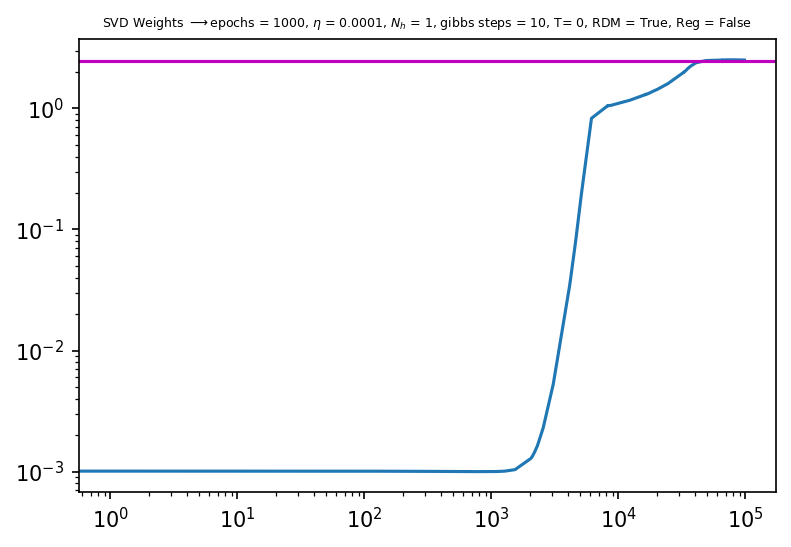

In [5]:
myRBMG2.PlotW()
plt.axhline(y=2*np.sqrt(1.5), color='m', linestyle='-', label='Línea Horizontal')


In [6]:
f = h5py.File(filename,'r')
alltime = np.sort(f['alltime'])
alltime

array([         0,          1,          2,          4,          6,
                8,         10,         12,         16,         18,
               20,         24,         32,         34,         36,
               40,         48,         64,         66,         68,
               72,         80,         96,        128,        130,
              132,        136,        144,        160,        192,
              256,        258,        260,        264,        272,
              288,        320,        384,        512,        514,
              516,        520,        528,        544,        576,
              640,        768,       1024,       1026,       1028,
             1032,       1040,       1056,       1088,       1152,
             1280,       1536,       2048,       2050,       2052,
             2056,       2064,       2080,       2112,       2176,
             2304,       2560,       3072,       4096,       4098,
             4100,       4104,       4112,       4128,       4

**Training a otra temperatura aún mas baja**

In [25]:
L = 1000
J = 1
h = 0
beta = 2
it = 80

# c - matriz axb
# Data - Tensor (axb,iter)

nro = 1000
Data = np.zeros([L,nro])

for i in range(nro):
    a,b,c = HB(L,J,h,it,beta)
    Data[:,i] = c
    
filename = "beta2.h5py"
import h5py
with h5py.File(filename, "w") as f:
    dset = f.create_dataset("Data", data=Data)

In [204]:

filename = "beta2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 5e-4
gibbs_steps = 10
epoch_max = 2000
T = 0



filename = 'files/RDMG_CWM_2_n1_b100_l5e4_k10_e2k.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG3 = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3959/1141569235.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


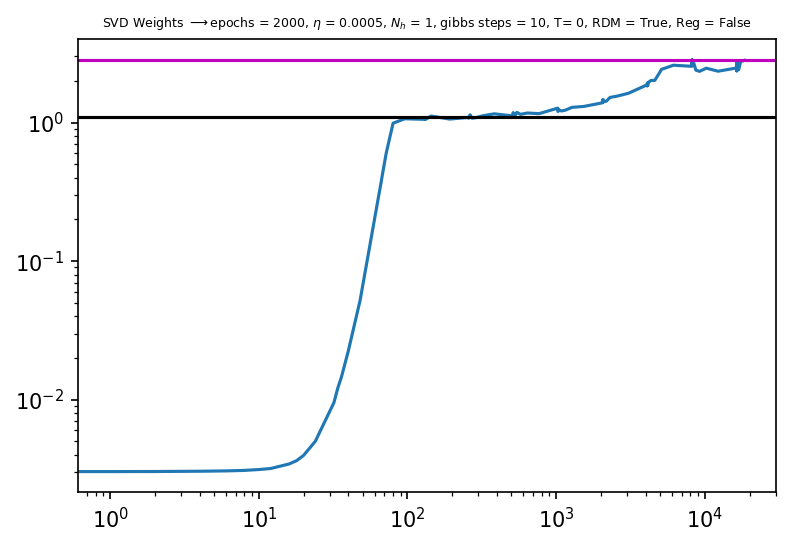

In [207]:
myRBMG3.PlotW()
plt.axhline(y=1.1, color='k', linestyle='-', label='Línea Horizontal')
plt.axhline(y=2*np.sqrt(2), color='m', linestyle='-', label='Línea Horizontal')

**Con los bias visibles inicializados en cero** 

In [13]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_bv0_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG4 = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_18858/1728256492.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [14]:
myRBMG4.train(D)

It =  0 loss tensor(50.0020)
It =  1 loss tensor(25.0004)
It =  2 loss tensor(16.6678)
It =  3 loss tensor(12.4983)
It =  4 loss tensor(10.0033)
It =  5 loss tensor(8.3437)
It =  6 loss tensor(7.1676)
It =  7 loss tensor(6.2699)
It =  8 loss tensor(5.5752)
It =  9 loss tensor(5.0168)
It =  10 loss tensor(4.5626)
It =  11 loss tensor(4.1791)
It =  12 loss tensor(3.8590)
It =  13 loss tensor(3.5836)
It =  14 loss tensor(3.3444)
It =  15 loss tensor(3.1377)
It =  16 loss tensor(2.9514)
It =  17 loss tensor(2.7860)
It =  18 loss tensor(2.6415)
It =  19 loss tensor(2.5093)
It =  20 loss tensor(2.3887)
It =  21 loss tensor(2.2813)
It =  22 loss tensor(2.1820)
It =  23 loss tensor(2.0901)
It =  24 loss tensor(2.0068)
It =  25 loss tensor(1.9299)
It =  26 loss tensor(1.8584)
It =  27 loss tensor(1.7913)
It =  28 loss tensor(1.7295)
It =  29 loss tensor(1.6728)
It =  30 loss tensor(1.6189)
It =  31 loss tensor(1.5675)
It =  32 loss tensor(1.5207)
It =  33 loss tensor(1.4761)
It =  34 loss tenso

It =  277 loss tensor(0.1808)
It =  278 loss tensor(0.1799)
It =  279 loss tensor(0.1793)
It =  280 loss tensor(0.1785)
It =  281 loss tensor(0.1779)
It =  282 loss tensor(0.1776)
It =  283 loss tensor(0.1769)
It =  284 loss tensor(0.1762)
It =  285 loss tensor(0.1751)
It =  286 loss tensor(0.1744)
It =  287 loss tensor(0.1739)
It =  288 loss tensor(0.1737)
It =  289 loss tensor(0.1729)
It =  290 loss tensor(0.1729)
It =  291 loss tensor(0.1725)
It =  292 loss tensor(0.1713)
It =  293 loss tensor(0.1707)
It =  294 loss tensor(0.1699)
It =  295 loss tensor(0.1692)
It =  296 loss tensor(0.1690)
It =  297 loss tensor(0.1681)
It =  298 loss tensor(0.1682)
It =  299 loss tensor(0.1675)
It =  300 loss tensor(0.1670)
It =  301 loss tensor(0.1665)
It =  302 loss tensor(0.1663)
It =  303 loss tensor(0.1654)
It =  304 loss tensor(0.1642)
It =  305 loss tensor(0.1636)
It =  306 loss tensor(0.1629)
It =  307 loss tensor(0.1632)
It =  308 loss tensor(0.1626)
It =  309 loss tensor(0.1615)
It =  310 

It =  551 loss tensor(0.0897)
It =  552 loss tensor(0.0905)
It =  553 loss tensor(0.0910)
It =  554 loss tensor(0.0903)
It =  555 loss tensor(0.0896)
It =  556 loss tensor(0.0894)
It =  557 loss tensor(0.0906)
It =  558 loss tensor(0.0896)
It =  559 loss tensor(0.0902)
It =  560 loss tensor(0.0889)
It =  561 loss tensor(0.0895)
It =  562 loss tensor(0.0879)
It =  563 loss tensor(0.0885)
It =  564 loss tensor(0.0891)
It =  565 loss tensor(0.0892)
It =  566 loss tensor(0.0879)
It =  567 loss tensor(0.0880)
It =  568 loss tensor(0.0864)
It =  569 loss tensor(0.0883)
It =  570 loss tensor(0.0873)
It =  571 loss tensor(0.0868)
It =  572 loss tensor(0.0866)
It =  573 loss tensor(0.0862)
It =  574 loss tensor(0.0880)
It =  575 loss tensor(0.0869)
It =  576 loss tensor(0.0872)
It =  577 loss tensor(0.0852)
It =  578 loss tensor(0.0872)
It =  579 loss tensor(0.0865)
It =  580 loss tensor(0.0864)
It =  581 loss tensor(0.0850)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0856)
It =  584 

It =  825 loss tensor(0.0610)
It =  826 loss tensor(0.0605)
It =  827 loss tensor(0.0612)
It =  828 loss tensor(0.0608)
It =  829 loss tensor(0.0599)
It =  830 loss tensor(0.0599)
It =  831 loss tensor(0.0601)
It =  832 loss tensor(0.0609)
It =  833 loss tensor(0.0596)
It =  834 loss tensor(0.0598)
It =  835 loss tensor(0.0604)
It =  836 loss tensor(0.0589)
It =  837 loss tensor(0.0592)
It =  838 loss tensor(0.0603)
It =  839 loss tensor(0.0607)
It =  840 loss tensor(0.0600)
It =  841 loss tensor(0.0588)
It =  842 loss tensor(0.0590)
It =  843 loss tensor(0.0589)
It =  844 loss tensor(0.0596)
It =  845 loss tensor(0.0589)
It =  846 loss tensor(0.0598)
It =  847 loss tensor(0.0584)
It =  848 loss tensor(0.0588)
It =  849 loss tensor(0.0587)
It =  850 loss tensor(0.0584)
It =  851 loss tensor(0.0584)
It =  852 loss tensor(0.0588)
It =  853 loss tensor(0.0579)
It =  854 loss tensor(0.0589)
It =  855 loss tensor(0.0583)
It =  856 loss tensor(0.0585)
It =  857 loss tensor(0.0581)
It =  858 

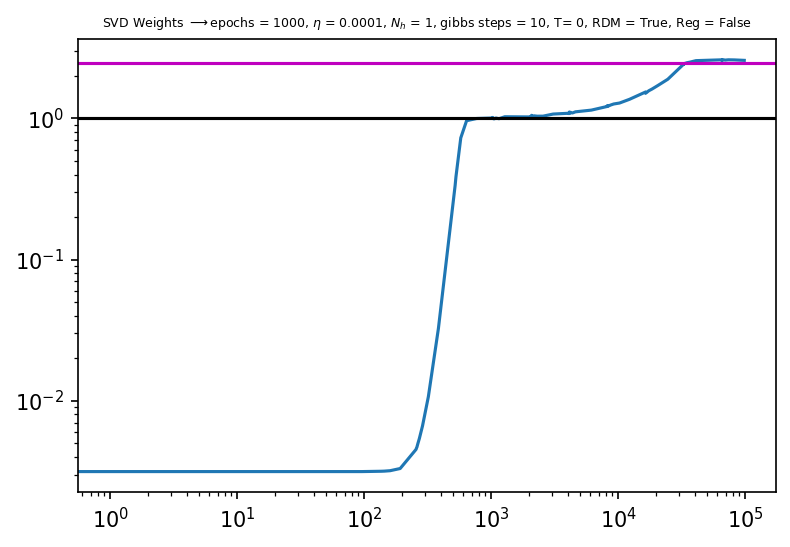

In [15]:
myRBMG4.PlotW()
plt.axhline(y=1, color='k', linestyle='-', label='Línea Horizontal')
plt.axhline(y=2*np.sqrt(1.5), color='m', linestyle='-', label='Línea Horizontal')

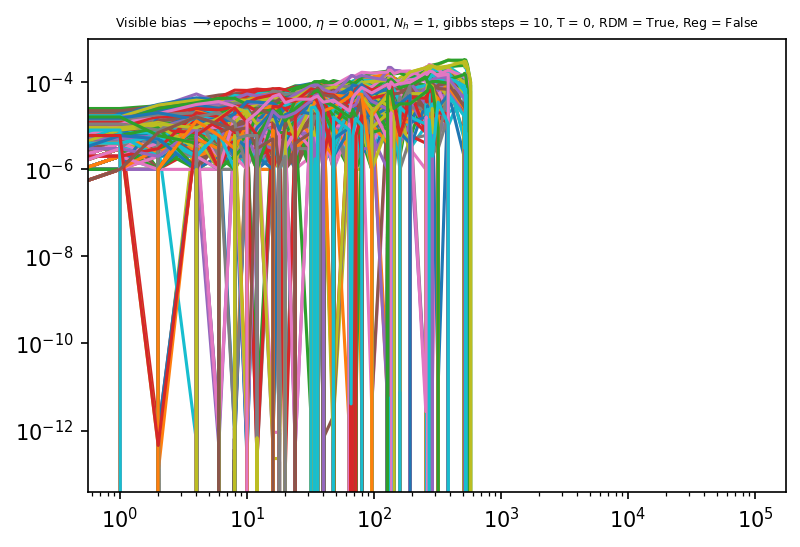

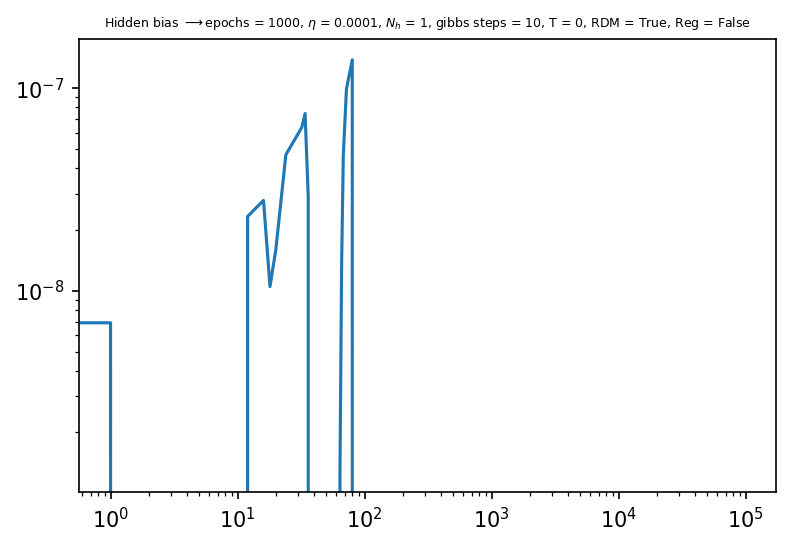

In [16]:
myRBMG4.PlotBias()

In [21]:
n_vis = D.shape[0]
n_hid = 500
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 5e-3
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_n500_b100_l5e3_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

In [14]:
Ns = 10000
device = 'cpu'
mnist_trainset = datasets.MNIST('dataset/', train=True, download=True)
D = mnist_trainset.data[:Ns,:,:].reshape(Ns,28*28).float().to(device) / 255.0
D = (D > 0.3) * 1.0
D = D.t()
time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

In [15]:
torch.mean(torch.mm(D,D.t()))/10000

tensor(0.0252)

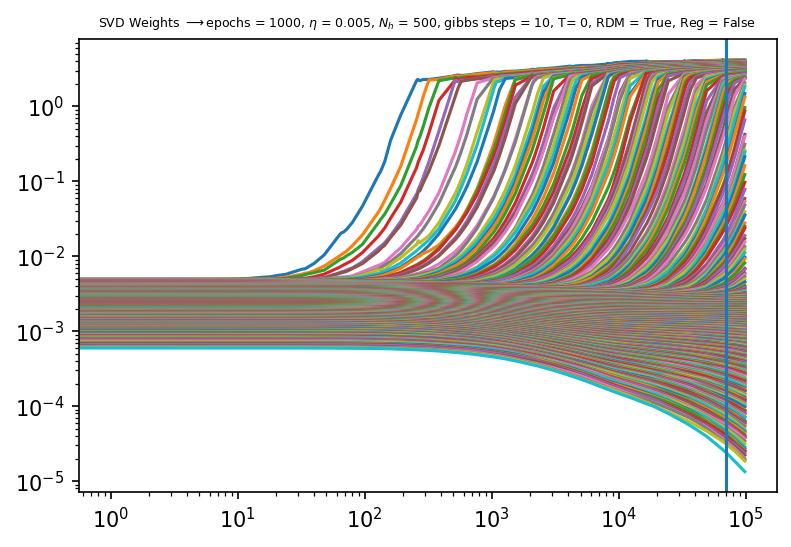

In [24]:
myRBMG.PlotW()
plt.axvline(x=69632,)

In [20]:
alltime = np.sort(f['alltime'])
alltime

array([            0,             1,             2,             4,
                   6,             8,            10,            12,
                  16,            18,            20,            24,
                  32,            34,            36,            40,
                  48,            64,            66,            68,
                  72,            80,            96,           128,
                 130,           132,           136,           144,
                 160,           192,           256,           258,
                 260,           264,           272,           288,
                 320,           384,           512,           514,
                 516,           520,           528,           544,
                 576,           640,           768,          1024,
                1026,          1028,          1032,          1040,
                1056,          1088,          1152,          1280,
                1536,          2048,          2050,          2

tensor([4.1195e+00, 4.0888e+00, 4.0267e+00, 3.9738e+00, 3.9386e+00, 3.9317e+00,
        3.8982e+00, 3.8723e+00, 3.8510e+00, 3.8313e+00, 3.8085e+00, 3.7952e+00,
        3.7815e+00, 3.7554e+00, 3.7426e+00, 3.7343e+00, 3.7162e+00, 3.7089e+00,
        3.6925e+00, 3.6813e+00, 3.6505e+00, 3.6282e+00, 3.6247e+00, 3.6045e+00,
        3.5988e+00, 3.5897e+00, 3.5809e+00, 3.5600e+00, 3.5569e+00, 3.5451e+00,
        3.5314e+00, 3.5205e+00, 3.5106e+00, 3.5066e+00, 3.4953e+00, 3.4773e+00,
        3.4691e+00, 3.4599e+00, 3.4487e+00, 3.4387e+00, 3.4292e+00, 3.4168e+00,
        3.4076e+00, 3.3940e+00, 3.3844e+00, 3.3730e+00, 3.3575e+00, 3.3502e+00,
        3.3388e+00, 3.3295e+00, 3.3216e+00, 3.2999e+00, 3.2749e+00, 3.2682e+00,
        3.2551e+00, 3.2419e+00, 3.2310e+00, 3.2091e+00, 3.1964e+00, 3.1614e+00,
        3.1493e+00, 3.1403e+00, 3.1122e+00, 3.1061e+00, 3.0914e+00, 3.0878e+00,
        3.0625e+00, 3.0579e+00, 3.0407e+00, 2.9958e+00, 2.9866e+00, 2.9556e+00,
        2.9396e+00, 2.9224e+00, 2.8901e+

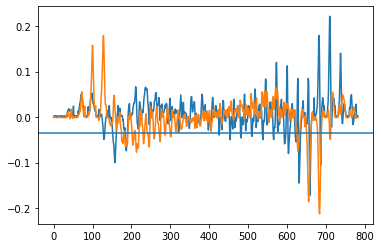

In [27]:
ep=69632
W = torch.tensor(f['W'+str(ep)])   
U,Σ,V=torch.svd(W)
print(Σ)
plt.plot(V[:,0]);

ep=98304
W = torch.tensor(f['W'+str(ep)])   
U,Σ,V=torch.svd(W)
plt.plot(V[:,0])
print(Σ)
plt.axhline(y=-1./np.sqrt(784,));

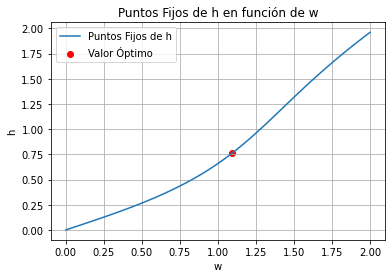

Valor óptimo de h: 0.7592649032316335
Valor óptimo de w: 1.090909090909091


In [31]:
m0 = 0.957504843301097
m = (m0+1)/2
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def fixed_point_iteration(w_values, initial_h, max_iterations=100, tolerance=1e-6):
    h_values = []
    for w in w_values:
        h = initial_h
        for _ in range(max_iterations):
            h_next = sigmoid(h * w) * w
            if abs(h_next - h) < tolerance:
                h = h_next
                break
            h = h_next
        h_values.append(h)
    return h_values

def optimal_values(w_values, h_values):

    optimal_h = None
    optimal_w = None
    min_difference = float('inf')
    for i, h in enumerate(h_values):
        w = w_values[i]
        sigmoid_hw = sigmoid(h * w)
        difference = abs(m**2 - m + 0.5 - sigmoid_hw**2)
        if difference < min_difference:
            min_difference = difference
            optimal_h = h
            optimal_w = w
    return optimal_h, optimal_w

# Definir rango de valores de w
w_values = np.linspace(0, 2, 100)

# Calcular puntos fijos de h
initial_h = 0.5
h_values = fixed_point_iteration(w_values, initial_h)

# Encontrar valores óptimos de h y w
optimal_h, optimal_w = optimal_values(w_values, h_values)

# Graficar los puntos fijos de h en función de w
plt.plot(w_values, h_values, label='Puntos Fijos de h')
plt.scatter(optimal_w, optimal_h, color='red', label='Valor Óptimo')
plt.xlabel('w')
plt.ylabel('h')
plt.title('Puntos Fijos de h en función de w')
plt.legend()
plt.grid(True)
plt.show()

print("Valor óptimo de h:", optimal_h)
print("Valor óptimo de w:", optimal_w)


In [33]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())  

D = torch.tensor(d,dtype = torch.float)

time = np.linspace(0,10000,10001).astype(int)
time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_muchost.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_4035/58116329.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [34]:
len(time)

10001

In [35]:
myRBMG.SetVisBias(D)
myRBMG.train(D)

It =  0 loss tensor(49.9723)
It =  1 loss tensor(24.9881)
It =  2 loss tensor(16.6497)
It =  3 loss tensor(12.5038)
It =  4 loss tensor(9.9918)
It =  5 loss tensor(8.3436)
It =  6 loss tensor(7.1665)
It =  7 loss tensor(6.2726)
It =  8 loss tensor(5.5736)
It =  9 loss tensor(5.0167)
It =  10 loss tensor(4.5589)
It =  11 loss tensor(4.1817)
It =  12 loss tensor(3.8611)
It =  13 loss tensor(3.5835)
It =  14 loss tensor(3.3458)
It =  15 loss tensor(3.1361)
It =  16 loss tensor(2.9506)
It =  17 loss tensor(2.7878)
It =  18 loss tensor(2.6405)
It =  19 loss tensor(2.5089)
It =  20 loss tensor(2.3898)
It =  21 loss tensor(2.2808)
It =  22 loss tensor(2.1812)
It =  23 loss tensor(2.0911)
It =  24 loss tensor(2.0065)
It =  25 loss tensor(1.9292)
It =  26 loss tensor(1.8589)
It =  27 loss tensor(1.7914)
It =  28 loss tensor(1.7307)
It =  29 loss tensor(1.6722)
It =  30 loss tensor(1.6180)
It =  31 loss tensor(1.5675)
It =  32 loss tensor(1.5199)
It =  33 loss tensor(1.4761)
It =  34 loss tensor

It =  277 loss tensor(0.1806)
It =  278 loss tensor(0.1804)
It =  279 loss tensor(0.1794)
It =  280 loss tensor(0.1788)
It =  281 loss tensor(0.1780)
It =  282 loss tensor(0.1771)
It =  283 loss tensor(0.1766)
It =  284 loss tensor(0.1764)
It =  285 loss tensor(0.1750)
It =  286 loss tensor(0.1748)
It =  287 loss tensor(0.1744)
It =  288 loss tensor(0.1738)
It =  289 loss tensor(0.1728)
It =  290 loss tensor(0.1728)
It =  291 loss tensor(0.1721)
It =  292 loss tensor(0.1716)
It =  293 loss tensor(0.1707)
It =  294 loss tensor(0.1694)
It =  295 loss tensor(0.1693)
It =  296 loss tensor(0.1689)
It =  297 loss tensor(0.1689)
It =  298 loss tensor(0.1683)
It =  299 loss tensor(0.1669)
It =  300 loss tensor(0.1662)
It =  301 loss tensor(0.1662)
It =  302 loss tensor(0.1656)
It =  303 loss tensor(0.1645)
It =  304 loss tensor(0.1639)
It =  305 loss tensor(0.1638)
It =  306 loss tensor(0.1637)
It =  307 loss tensor(0.1628)
It =  308 loss tensor(0.1628)
It =  309 loss tensor(0.1608)
It =  310 

It =  551 loss tensor(0.0909)
It =  552 loss tensor(0.0910)
It =  553 loss tensor(0.0907)
It =  554 loss tensor(0.0906)
It =  555 loss tensor(0.0901)
It =  556 loss tensor(0.0902)
It =  557 loss tensor(0.0893)
It =  558 loss tensor(0.0891)
It =  559 loss tensor(0.0882)
It =  560 loss tensor(0.0881)
It =  561 loss tensor(0.0893)
It =  562 loss tensor(0.0883)
It =  563 loss tensor(0.0881)
It =  564 loss tensor(0.0885)
It =  565 loss tensor(0.0893)
It =  566 loss tensor(0.0891)
It =  567 loss tensor(0.0861)
It =  568 loss tensor(0.0878)
It =  569 loss tensor(0.0879)
It =  570 loss tensor(0.0877)
It =  571 loss tensor(0.0866)
It =  572 loss tensor(0.0871)
It =  573 loss tensor(0.0881)
It =  574 loss tensor(0.0869)
It =  575 loss tensor(0.0869)
It =  576 loss tensor(0.0862)
It =  577 loss tensor(0.0862)
It =  578 loss tensor(0.0872)
It =  579 loss tensor(0.0857)
It =  580 loss tensor(0.0857)
It =  581 loss tensor(0.0861)
It =  582 loss tensor(0.0856)
It =  583 loss tensor(0.0868)
It =  584 

It =  825 loss tensor(0.0600)
It =  826 loss tensor(0.0600)
It =  827 loss tensor(0.0608)
It =  828 loss tensor(0.0606)
It =  829 loss tensor(0.0610)
It =  830 loss tensor(0.0604)
It =  831 loss tensor(0.0607)
It =  832 loss tensor(0.0598)
It =  833 loss tensor(0.0611)
It =  834 loss tensor(0.0599)
It =  835 loss tensor(0.0591)
It =  836 loss tensor(0.0594)
It =  837 loss tensor(0.0600)
It =  838 loss tensor(0.0590)
It =  839 loss tensor(0.0592)
It =  840 loss tensor(0.0592)
It =  841 loss tensor(0.0589)
It =  842 loss tensor(0.0588)
It =  843 loss tensor(0.0596)
It =  844 loss tensor(0.0590)
It =  845 loss tensor(0.0589)
It =  846 loss tensor(0.0595)
It =  847 loss tensor(0.0584)
It =  848 loss tensor(0.0584)
It =  849 loss tensor(0.0590)
It =  850 loss tensor(0.0596)
It =  851 loss tensor(0.0584)
It =  852 loss tensor(0.0584)
It =  853 loss tensor(0.0589)
It =  854 loss tensor(0.0583)
It =  855 loss tensor(0.0583)
It =  856 loss tensor(0.0588)
It =  857 loss tensor(0.0587)
It =  858 

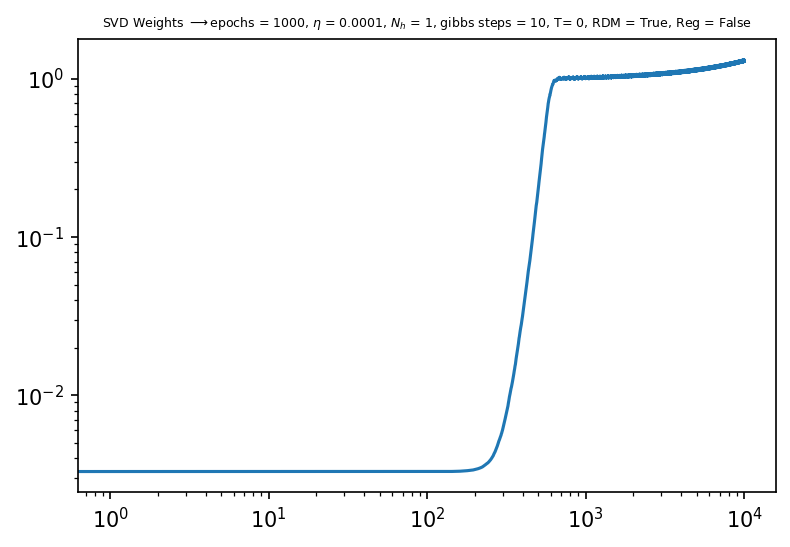

In [36]:
myRBMG.PlotW()

In [7]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling2(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)

        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)

            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2)).item()
            
            
        return np.array(m),np.array(chi),v #estoy guardando todas las m y la última v

In [12]:
time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

tlist = time22

allt= []
allm = []
allchi = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,10000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling2(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)

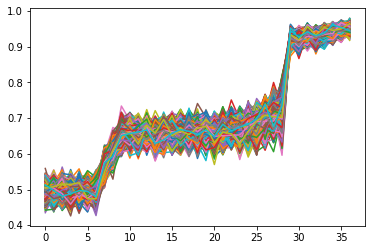

In [13]:
plt.plot(allm);

In [2]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)

        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
            
        q = []
        q2 = []
        for i in range (N):
            for j in range (i+1,N):
                
                f = torch.mean((2*v[:,i]-1)*(2*v[:,j]-1))
                q.append(f) 
                q2.append(torch.pow(f, 2))
        
            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2).item())
        chi2 = ((np.mean(q2)-np.mean(q)**2)/1000).item()
            
            
        return np.array(m),np.array(chi),np.array(chi2),v #estoy guardando todas las m y la última v

In [5]:
time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

tlist = time22

allt= []
allm = []
allchi = []
allchi2 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.zeros(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    allchi2.append(chi2)

/tmp/ipykernel_6011/4032399316.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


In [28]:
time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

tlist = time22
alls2 = []
allt2= []
allm2 = []
allchi3 = []
allchi23 = []
filename = 'files/RDMG_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi3.append(chi)
    allchi23.append(chi2)
alls2 = torch.cat(tuple(alls2),dim=1)

In [29]:
filename =  'files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'

time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

tlist = time22
alls3 = []
allt3= []
allm3 = []
allchi4 = []
allchi24 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((100,1000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls3.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi4.append(chi)
    allchi24.append(chi2)
alls3 = torch.cat(tuple(alls3),dim=1)

In [41]:
filename =  'files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'

time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

tlist = time22
tlist = sorted(tlist, reverse=True)
alls4 = []
allt4= []
allm4 = []
allchi5 = []
allchi25 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((100,1000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls4.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt4.append(t)
    allm4.append(m)
    allchi5.append(chi)
    allchi25.append(chi2)
alls34= torch.cat(tuple(alls4),dim=1)

Text(0, 0.5, '$\\chi_q$')

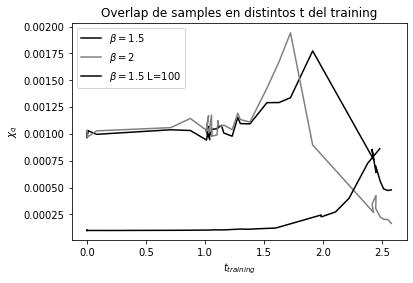

In [36]:
tiempos_uniformes = np.arange(len(allt))

y = np.array(allchi2)*1000
y2 = np.array(allchi23)*1000
plt.plot(alls.squeeze(0), y,'k',label = r'$\beta = 1.5$')
plt.plot(alls.squeeze(0), y2,'grey',label = r'$\beta = 2$')

y3 = np.array(allchi24)*100
plt.plot(alls3.squeeze(0), y3/10,'k',label = r'$\beta = 1.5$ L=100')

plt.legend()
plt.title('Overlap de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel(r'$\chi_q$')

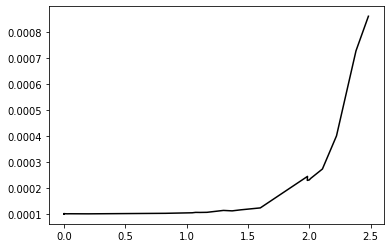

In [37]:
y3 = np.array(allchi24)*100
plt.plot(alls3.squeeze(0), y3/10,'k',label = r'$\beta = 1.5$ L=100')

AttributeError: 'list' object has no attribute 'squeeze'

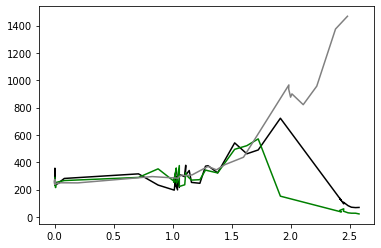

In [42]:
tiempos_uniformes = np.arange(len(allt))


y = np.array(allchi)
y2 = np.array(allchi3)
plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5$')
plt.plot(alls.squeeze(0), y2*1000,'g',label = r'$\beta = 2$')
y3 = np.array(allchi4)
plt.plot(alls3.squeeze(0), y3*100,'gray',label = r'$\beta = 1.5$ L=100')

y5 = np.array(allchi5)
plt.plot(alls4.squeeze(0), y5*100,'gray',label = r'$\beta = 1.5$ L=100 inv')
plt.title('Susceptibilidad en distintos t del training')
plt.xlabel('$t_{training}$')
plt.legend()
plt.ylabel(r'$\chi$')

In [19]:
tlist = time22

alls  = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    _,s,_ = torch.svd(W)
    alls.append(s.reshape(s.shape[0],1))
alls = torch.cat(tuple(alls),dim=1)

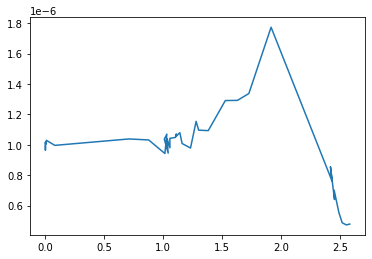

In [18]:

plt.plot(np.array(alls.squeeze(0)),allchi2)

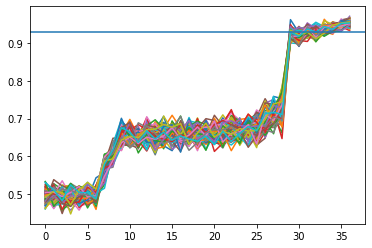

In [26]:
plt.plot(allm);
plt.axhline(y=0.93)

In [13]:
np.array(allchi2)*1000

array([0.00100881, 0.00103862, 0.00099852, 0.00100446, 0.00100104,
       0.00100865, 0.00099871, 0.00097843, 0.00097088, 0.00105159,
       0.00106678, 0.00098794, 0.00105364, 0.00108079, 0.00105966,
       0.00107122, 0.00108064, 0.0010769 , 0.00106652, 0.0010279 ,
       0.00104535, 0.00109167, 0.00110681, 0.00099414, 0.0010697 ,
       0.00121148, 0.00138221, 0.00119368, 0.00173589, 0.00078523,
       0.00091713, 0.00057542, 0.00061954, 0.00055326, 0.00042109,
       0.00035892, 0.00039969])

In [12]:
allchi2

[array(1.00881337e-06),
 array(1.03862345e-06),
 array(9.98520549e-07),
 array(1.0044583e-06),
 array(1.00103934e-06),
 array(1.00865294e-06),
 array(9.98706117e-07),
 array(9.78430652e-07),
 array(9.70878946e-07),
 array(1.05158617e-06),
 array(1.06678059e-06),
 array(9.87943453e-07),
 array(1.05364281e-06),
 array(1.08079412e-06),
 array(1.05966122e-06),
 array(1.07122208e-06),
 array(1.08064332e-06),
 array(1.07690156e-06),
 array(1.06652059e-06),
 array(1.02789667e-06),
 array(1.04534506e-06),
 array(1.09166676e-06),
 array(1.10681232e-06),
 array(9.94140857e-07),
 array(1.06970457e-06),
 array(1.21147659e-06),
 array(1.38221137e-06),
 array(1.19368371e-06),
 array(1.73588986e-06),
 array(7.85226498e-07),
 array(9.17134807e-07),
 array(5.7541766e-07),
 array(6.19544135e-07),
 array(5.53258882e-07),
 array(4.21088243e-07),
 array(3.58917634e-07),
 array(3.9968818e-07)]

In [50]:

tlist = [768]

allt= []
allm = []
allchi = []
allchi2 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,10),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    h,mh = Hsampling(W,b_h,v)
    v,mv = Vsampling(W,b_v,h)
    
    it = 100
    for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)

In [61]:
q = []
for i in range (N):
    for j in range (i+1,N):
            q.append((2*v[:,i]-1)*(2*v[:,j]-1))

In [53]:
chi2

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [29]:
torch.mean((2*X[:,1]-1)*(2*X[:,2]-1))

tensor(0.0820)

In [34]:
W = torch.tensor(f['W'+str(ep)])
b_v = torch.tensor(f['bias_v'+str(ep)]) 
b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
m,chi,chi2,v = Sampling(X,W,b_h,b_v,it)

N = 10
for i in range (N):
    for j in range (i+1,N):
            q = torch.mean((2*v[:,i]-1)*(2*v[:,j]-1))
            q2 = torch.pow(q,2)

tensor(0.0174)